In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from scipy import stats

/var/folders/lr/2ljfkpxj1851pmkswdvzvnhm0000gn/T/ipykernel_4069/2214738656.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#Load sales of smartphones in India (Rupee)
data = pd.read_csv("Sales.csv")
data.head()

,Brands,Models,Colors,Memory,Storage,Camera,Rating,Selling Price,Original Price,Mobile,Discount,discount percentage
0,SAMSUNG,GALAXY M31S,Mirage Black,8 GB,128 GB,Yes,4.3,19330,20999,SAMSUNG GALAXY M31S,1669,7.947998
1,Nokia,3.2,Steel,2 GB,16 GB,Yes,3.8,10199,10199,Nokia 3.2,0,0.000000
2,realme,C2,Diamond Black,2 GB,NaN,Yes,4.4,6999,7999,realme C2,1000,12.501563
3,Infinix,Note 5,Ice Blue,4 GB,64 GB,Yes,4.2,12999,12999,Infinix Note 5,0,0.000000
4,Apple,iPhone 11,Black,4GB,64 GB,Yes,4.6,49900,49900,Apple iPhone 11,0,0.000000


In [3]:
data.dtypes

Brands                  object
Models                  object
Colors                  object
Memory                  object
Storage                 object
Camera                  object
Rating                 float64
Selling Price            int64
Original Price           int64
Mobile                  object
Discount                 int64
discount percentage    float64
dtype: object

In [4]:
data.describe()

,Rating,Selling Price,Original Price,Discount,discount percentage
count,2970.000000,3114.000000,3114.000000,3114.000000,3114.000000
mean,4.243098,26436.625562,28333.473025,1896.847463,6.086788
std,0.271991,30066.892622,31525.599889,5337.126176,11.106776
min,2.300000,1000.000000,1000.000000,-8000.000000,-160.320641
25%,4.100000,9990.000000,10030.250000,0.000000,0.000000
50%,4.300000,15000.000000,16889.500000,0.000000,0.000000
75%,4.400000,28999.000000,31500.000000,2000.000000,9.836388
max,5.000000,179900.000000,189999.000000,75000.000000,70.610305


In [5]:
data.shape

(3114, 12)

discount percentage    0.049209
Discount               0.351638
Rating                 0.451354
Selling Price          0.986097
Original Price         1.000000
Name: Original Price, dtype: float64


<Axes: >

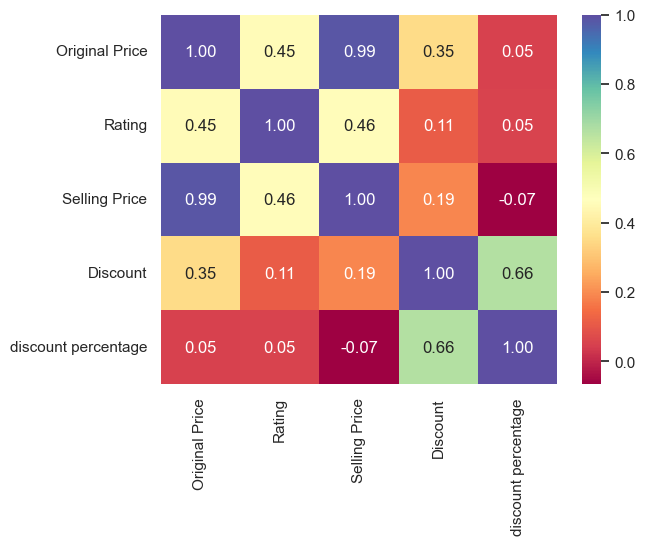

In [6]:
numeric_data = pd.DataFrame(data[["Original Price","Rating", "Selling Price", "Discount", "discount percentage"]])
corr = numeric_data.corr()

# Pearson Correlation Coefficient 
# measures the strength and direction of the relationship between the predictor and response variables
print(corr['Original Price'].sort_values())
sb.heatmap(corr, annot=True, cmap="Spectral", fmt='.2f')

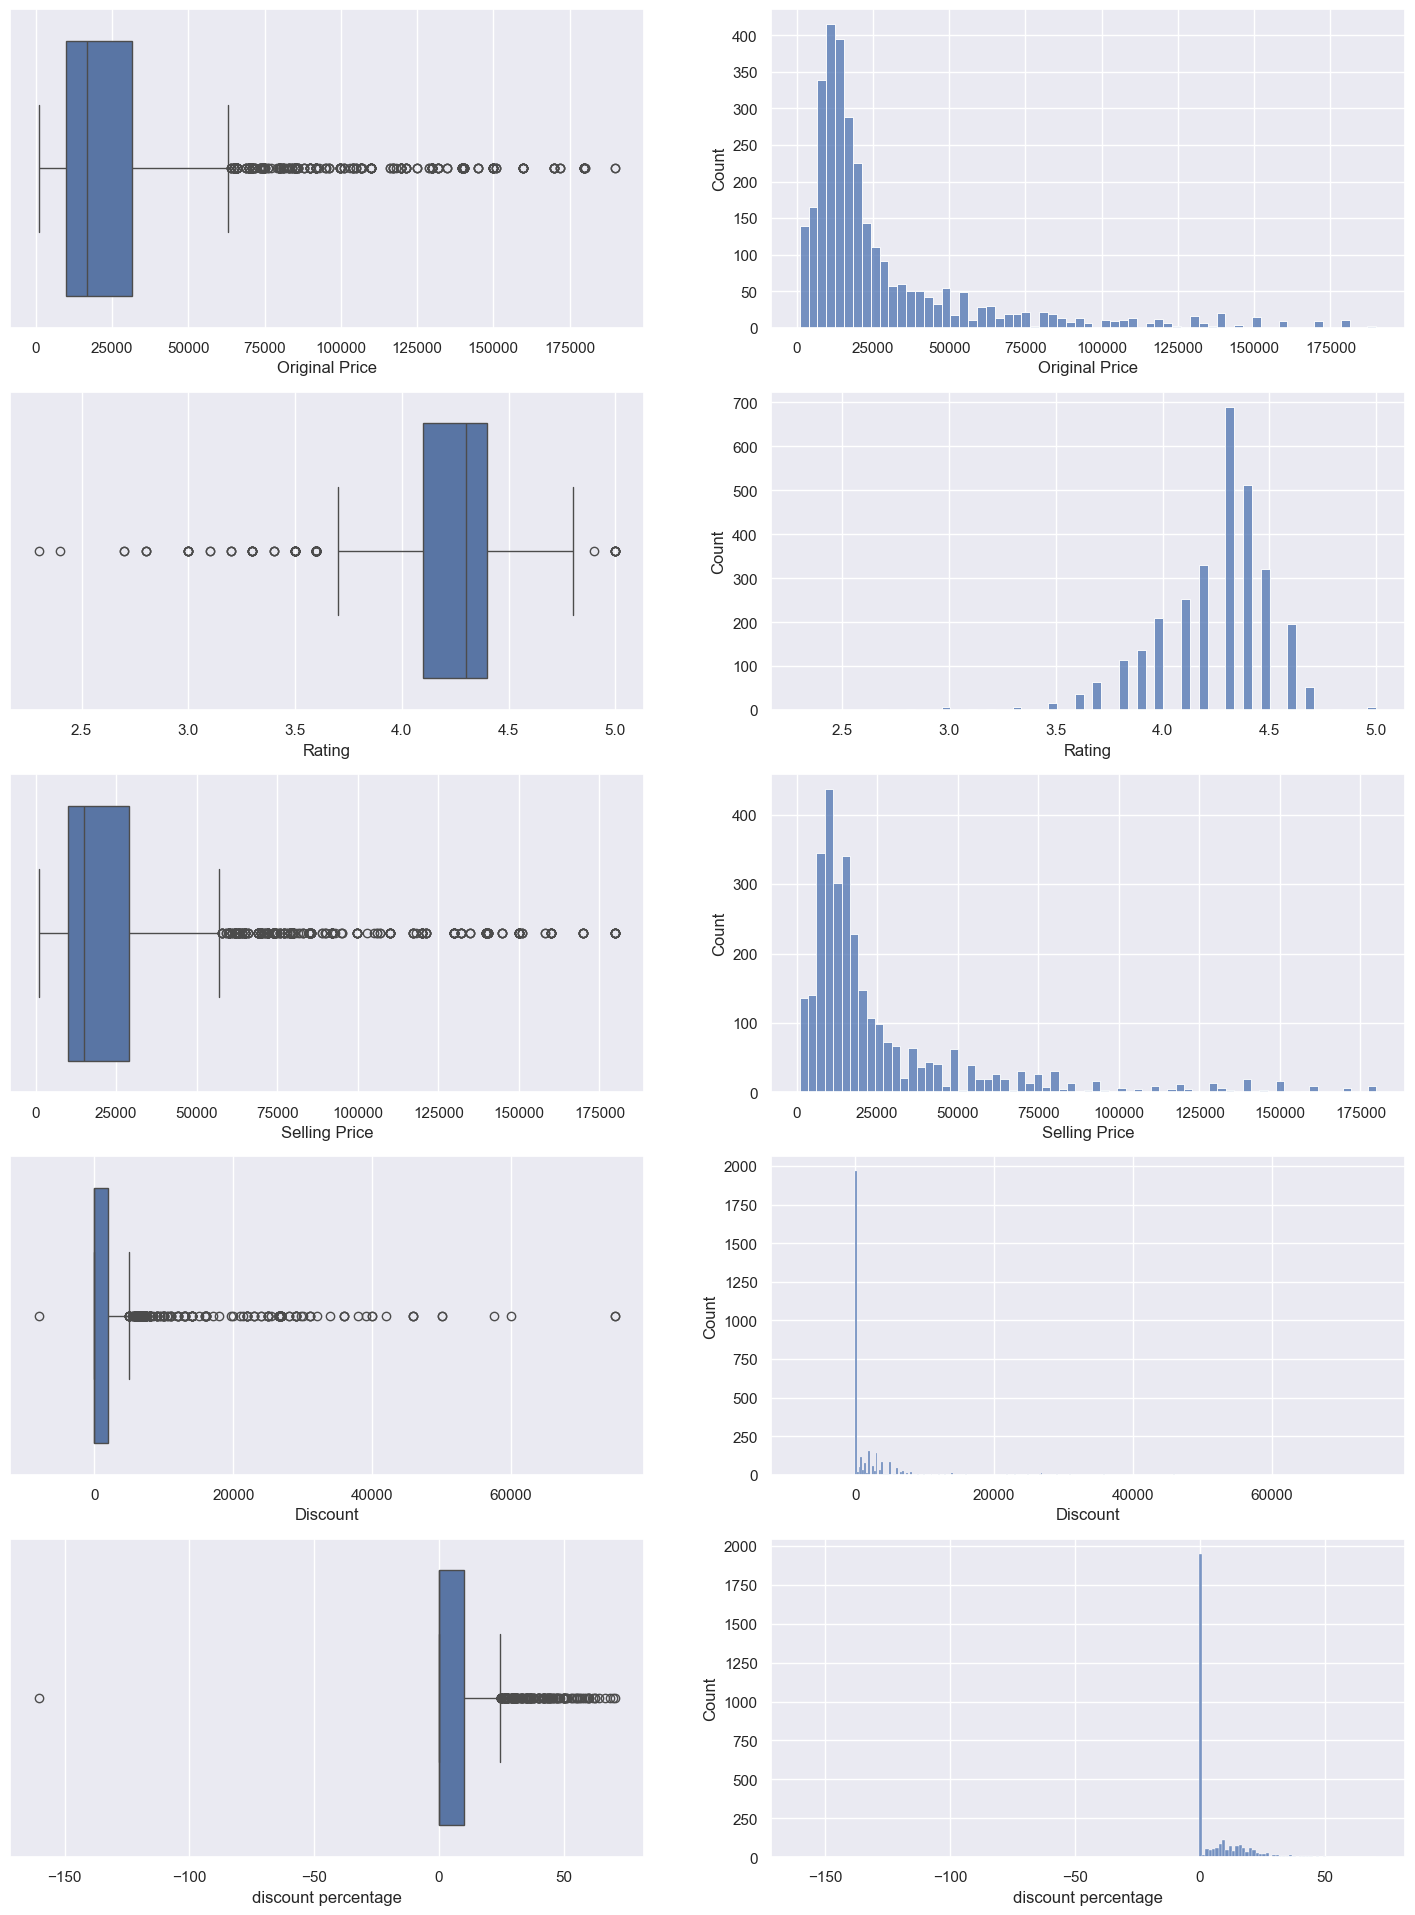

In [7]:
### Boxplots of numeric variables

var = ["Original Price", "Rating", "Selling Price", "Discount", "discount percentage"]
f, axes = plt.subplots(5,2, figsize=(18,24))

count = 0

for var in numeric_data:
    sb.boxplot(data=numeric_data[var], orient="h", ax = axes[count,0])
    sb.histplot(data = numeric_data[var], ax = axes[count,1])
    count += 1

In [8]:
#Calculate outliers
Q1 = data['Original Price'].quantile(0.25)
Q3 = data['Original Price'].quantile(0.75)

IQR = Q3-Q1

lowerBound = Q1-(1.5*IQR)
upperBound = Q3+(1.5*IQR)

#identify all outliers

outliers = data[(data['Original Price'] < lowerBound) | (data['Original Price']> upperBound)]

print("Number of outliers in Original Selling Price: {}".format(len(outliers)))

# data = data.query("Brands == 'Apple'")

Number of outliers in Original Selling Price: 345


In [9]:
#Function to remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3-Q1
    
    lowerBound = Q1-(1.5*IQR)
    upperBound = Q3+(1.5*IQR)
    
    df_filtered = df.loc[(df[column] >= lowerBound) & (df[column] <= upperBound)]
    
    return df_filtered


# Remove outliers in the original selling price
filtered_data = remove_outliers(data, "Original Price")
#df[df['Brands'].str.contains("Apple")].head(400)

In [10]:
#Count the number of null values in the data
filtered_data.isna().sum()

Brands                  0
Models                  0
Colors                  0
Memory                 29
Storage                36
Camera                  0
Rating                 85
Selling Price           0
Original Price          0
Mobile                  0
Discount                0
discount percentage     0
dtype: int64

In [11]:
#Remove all the null values in the data
filtered_data = filtered_data.dropna()

In [12]:
#After the removal of null values
filtered_data.shape

(2625, 12)

In [13]:
filtered_data['Storage'] = filtered_data['Storage'].str.replace("Expandable Upto", "")

In [14]:
#filtered_data["Memory"] = filtered_data['Memory'].str.replace('GB', " GB")
#filtered_data = filtered_data.reset_index()

#Convert to GB
def convert_to_gb(size_str):
    if "MB" in size_str:
        return float(size_str.replace("MB", "")) / 1000
    elif "TB" in size_str:
        return float(size_str.replace("TB", "")) * 1000
    elif "GB" in size_str:
        return float(size_str.replace("GB", ""))
    else:
        return None


filtered_data["Memory"] = filtered_data['Memory'].apply(convert_to_gb)
filtered_data['Storage'] = filtered_data['Storage'].apply(convert_to_gb)
filtered_data.head()

,Brands,Models,Colors,Memory,Storage,Camera,Rating,Selling Price,Original Price,Mobile,Discount,discount percentage
0,SAMSUNG,GALAXY M31S,Mirage Black,8.000,128.000,Yes,4.3,19330,20999,SAMSUNG GALAXY M31S,1669,7.947998
1,Nokia,3.2,Steel,2.000,16.000,Yes,3.8,10199,10199,Nokia 3.2,0,0.000000
3,Infinix,Note 5,Ice Blue,4.000,64.000,Yes,4.2,12999,12999,Infinix Note 5,0,0.000000
4,Apple,iPhone 11,Black,4.000,64.000,Yes,4.6,49900,49900,Apple iPhone 11,0,0.000000
5,GIONEE,L800,Black,0.008,0.016,Yes,4.0,2199,2199,GIONEE L800,0,0.000000


In [15]:
filtered_data.dtypes

Brands                  object
Models                  object
Colors                  object
Memory                 float64
Storage                float64
Camera                  object
Rating                 float64
Selling Price            int64
Original Price           int64
Mobile                  object
Discount                 int64
discount percentage    float64
dtype: object

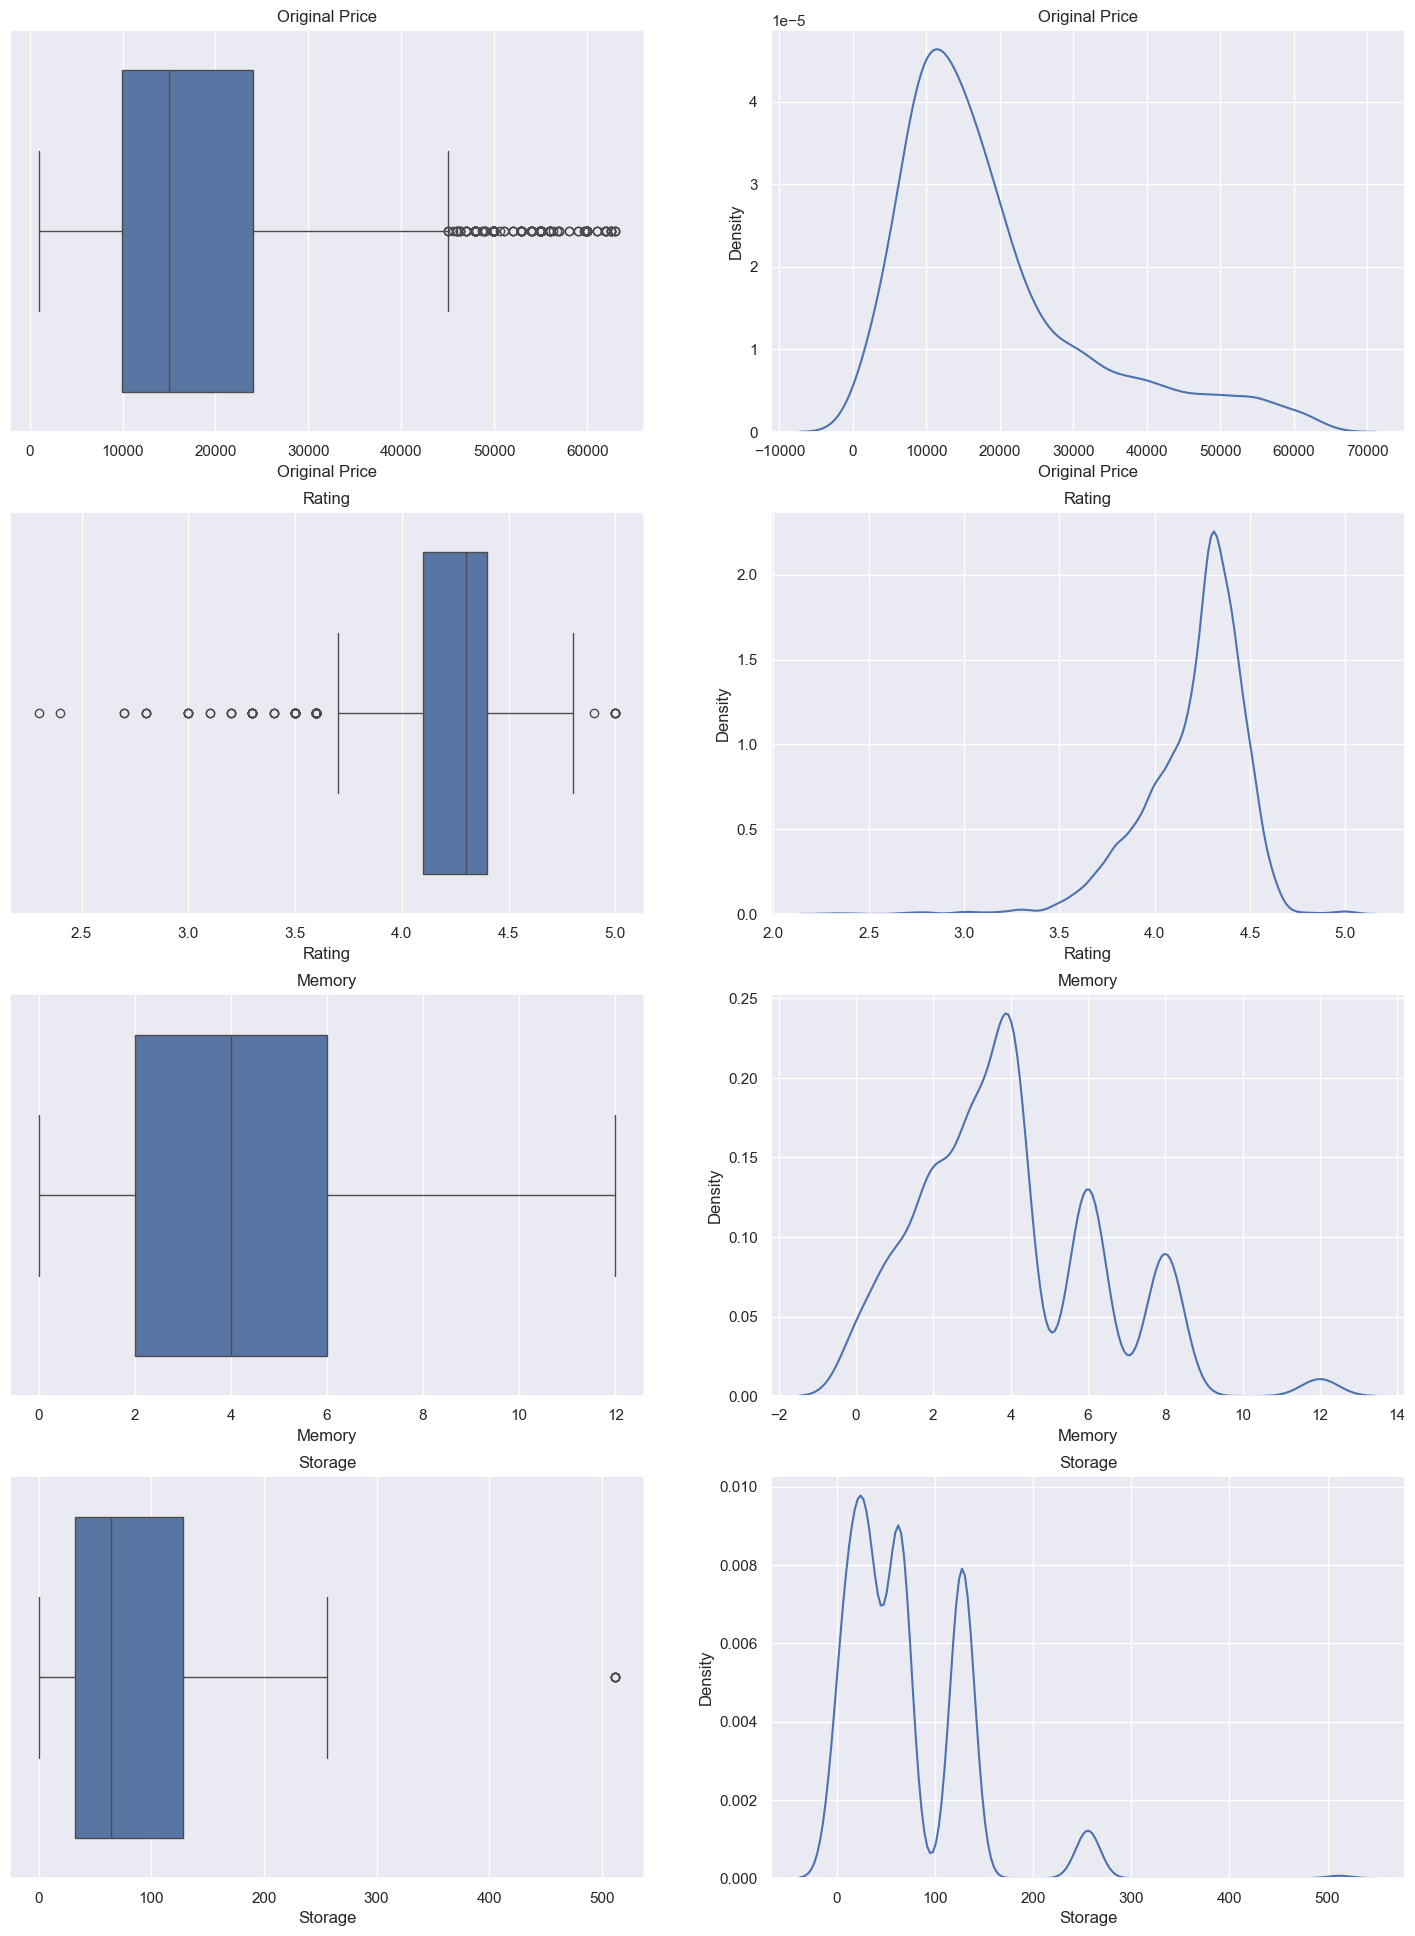

In [16]:
var = ["Original Price", "Rating", "Memory", "Storage"]
filtered_numeric_data = pd.DataFrame(filtered_data[["Original Price","Rating", "Memory", "Storage"]])
count = 0

f, axes = plt.subplots(4,2, figsize=(18,24))
for var in filtered_numeric_data:
    sb.boxplot(data = filtered_numeric_data[var], orient="h", ax = axes[count,0]).set_title(var)
    sb.kdeplot(data=filtered_numeric_data[var], ax = axes[count,1]).set_title(var)
    count+=1

Rating            0.417703
Memory            0.467205
Storage           0.540914
Original Price    1.000000
Name: Original Price, dtype: float64


<Axes: >

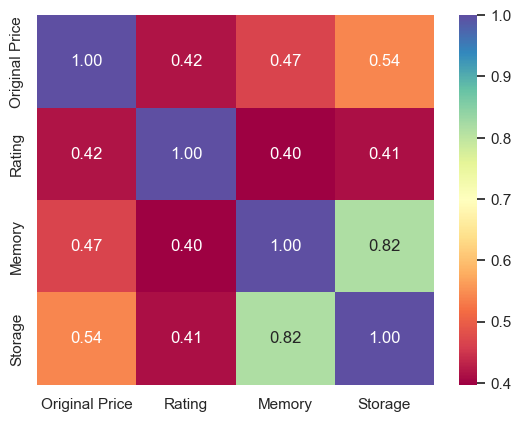

In [17]:
corr = filtered_numeric_data.corr()
print(corr['Original Price'].sort_values())
sb.heatmap(corr, annot=True, cmap="Spectral", fmt='.2f')

The relatively higher correlation coefficients of "Memory" (=0.47) and "Storage" (=0.54) variables with "Original Price" suggest that a decent linear regression model based on "Memory"/"Storage" as the predictor variables and "Original Price" as the response variable could be trained from the dataset  

Coefficients of Regression: 119.33190393698648
Intercept of Regression: 10704.962432806655


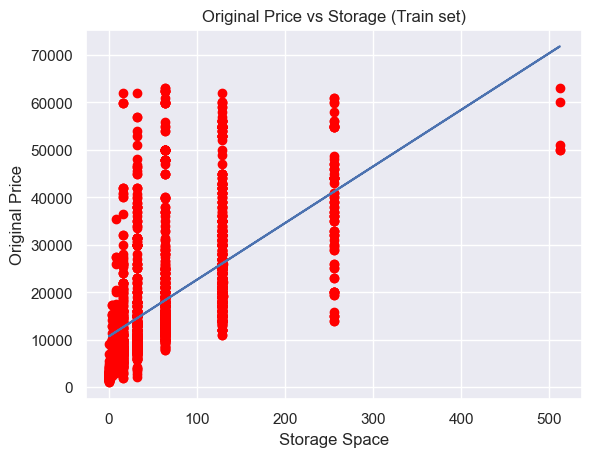

In [18]:
#Linear  Regression
storage = filtered_data[['Storage']] #Predictor
originalPrice = filtered_data['Original Price'] #Response

#Split the dataset into training and test set (80:20)
storage_train, storage_test, originalPrice_train, originalPrice_test = train_test_split(storage, originalPrice, test_size = 0.2)


#Fit linear regression into the training set
linreg = LinearRegression()
linreg.fit(storage_train, originalPrice_train)
print("Coefficients of Regression: {}".format(linreg.coef_[0])) 
print("Intercept of Regression: {}".format(linreg.intercept_)) 

#Plot the regression line
plt.scatter(storage_train, originalPrice_train, color='red')
plt.plot(storage_train, linreg.predict(storage_train))
plt.title("Original Price vs Storage (Train set)")
plt.xlabel('Storage Space')
plt.ylabel('Original Price')
plt.show()

Goodness of Fit of the Model Train Dataset
Explained Variance (R^2): 0.3073809452324411
Mean Squared Error (MSE): 120925489.43261044

Goodness of Fit of the Model Test Dataset
Explained Variance (R^2): 0.23115942010384227
Mean Squared Error (MSE): 137225483.18450108


Text(0, 0.5, 'Predicted values of the Response Variable (Test)')

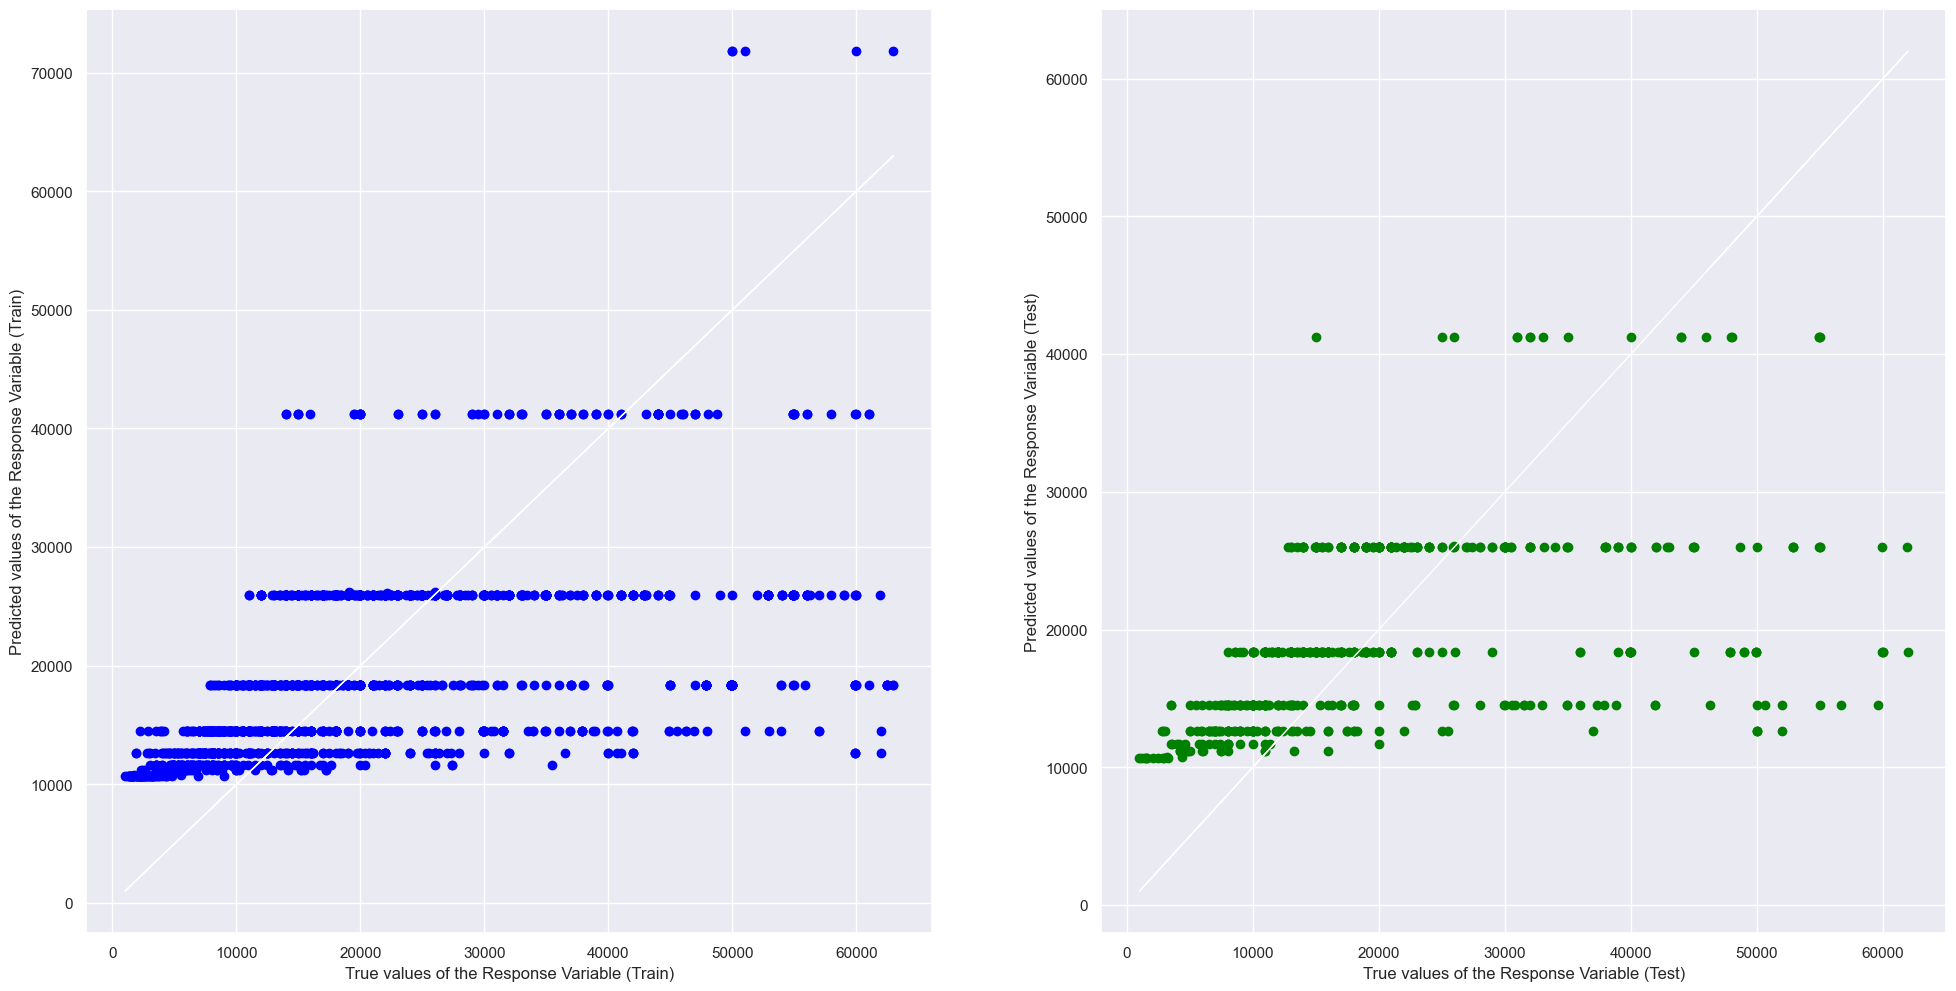

In [19]:
#Goodness of Fit of the model for the train set
originalPrice_test_pred = linreg.predict(storage_test)
originalPrice_train_pred = linreg.predict(storage_train)


#Goodness of Fit (on Train data)
print("Goodness of Fit of the Model Train Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(storage_train, originalPrice_train)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_train, originalPrice_train_pred)))
print()

#Goodness of Fit (on Test Data)
print("Goodness of Fit of the Model Test Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(storage_test, originalPrice_test)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_test, originalPrice_test_pred)))


#Plot the predictions vs the true values
f, axes = plt.subplots(1,2, figsize=(24,12))
axes[0].scatter(originalPrice_train, originalPrice_train_pred, color='blue')
axes[0].plot(originalPrice_train, originalPrice_train, 'w-', linewidth=1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")


axes[1].scatter(originalPrice_test, originalPrice_test_pred, color='green')
axes[1].plot(originalPrice_test, originalPrice_test, 'w-', linewidth=1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")

Coefficients of Regression: 2694.159450464974
Intercept of Regression: 8386.451856099091


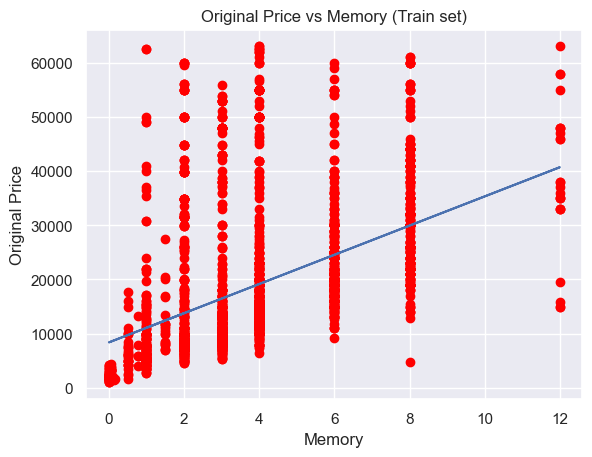

In [20]:
#Linear  Regression
memory = filtered_data[['Memory']] #Predictor
originalPrice = filtered_data['Original Price'] #Response

#Split the dataset into training and test set (80:20)
memory_train, memory_test, originalPrice_train, originalPrice_test = train_test_split(memory, originalPrice, test_size = 0.2)


#Fit linear regression into the training set
linreg = LinearRegression()
linreg.fit(memory_train, originalPrice_train)
print("Coefficients of Regression: {}".format(linreg.coef_[0])) 
print("Intercept of Regression: {}".format(linreg.intercept_)) 

#Plot the regression line
plt.scatter(memory_train, originalPrice_train, color='red')
plt.plot(memory_train, linreg.predict(memory_train))
plt.title("Original Price vs Memory (Train set)")
plt.xlabel('Memory')
plt.ylabel('Original Price')
plt.show()

Goodness of Fit of the Model Train Dataset
Explained Variance (R^2): 0.22338134656386588
Mean Squared Error (MSE): 133453762.46507557

Goodness of Fit of the Model Test Dataset
Explained Variance (R^2): 0.19831101073759683
Mean Squared Error (MSE): 152315051.3692896


Text(0, 0.5, 'Predicted values of the Response Variable (Test)')

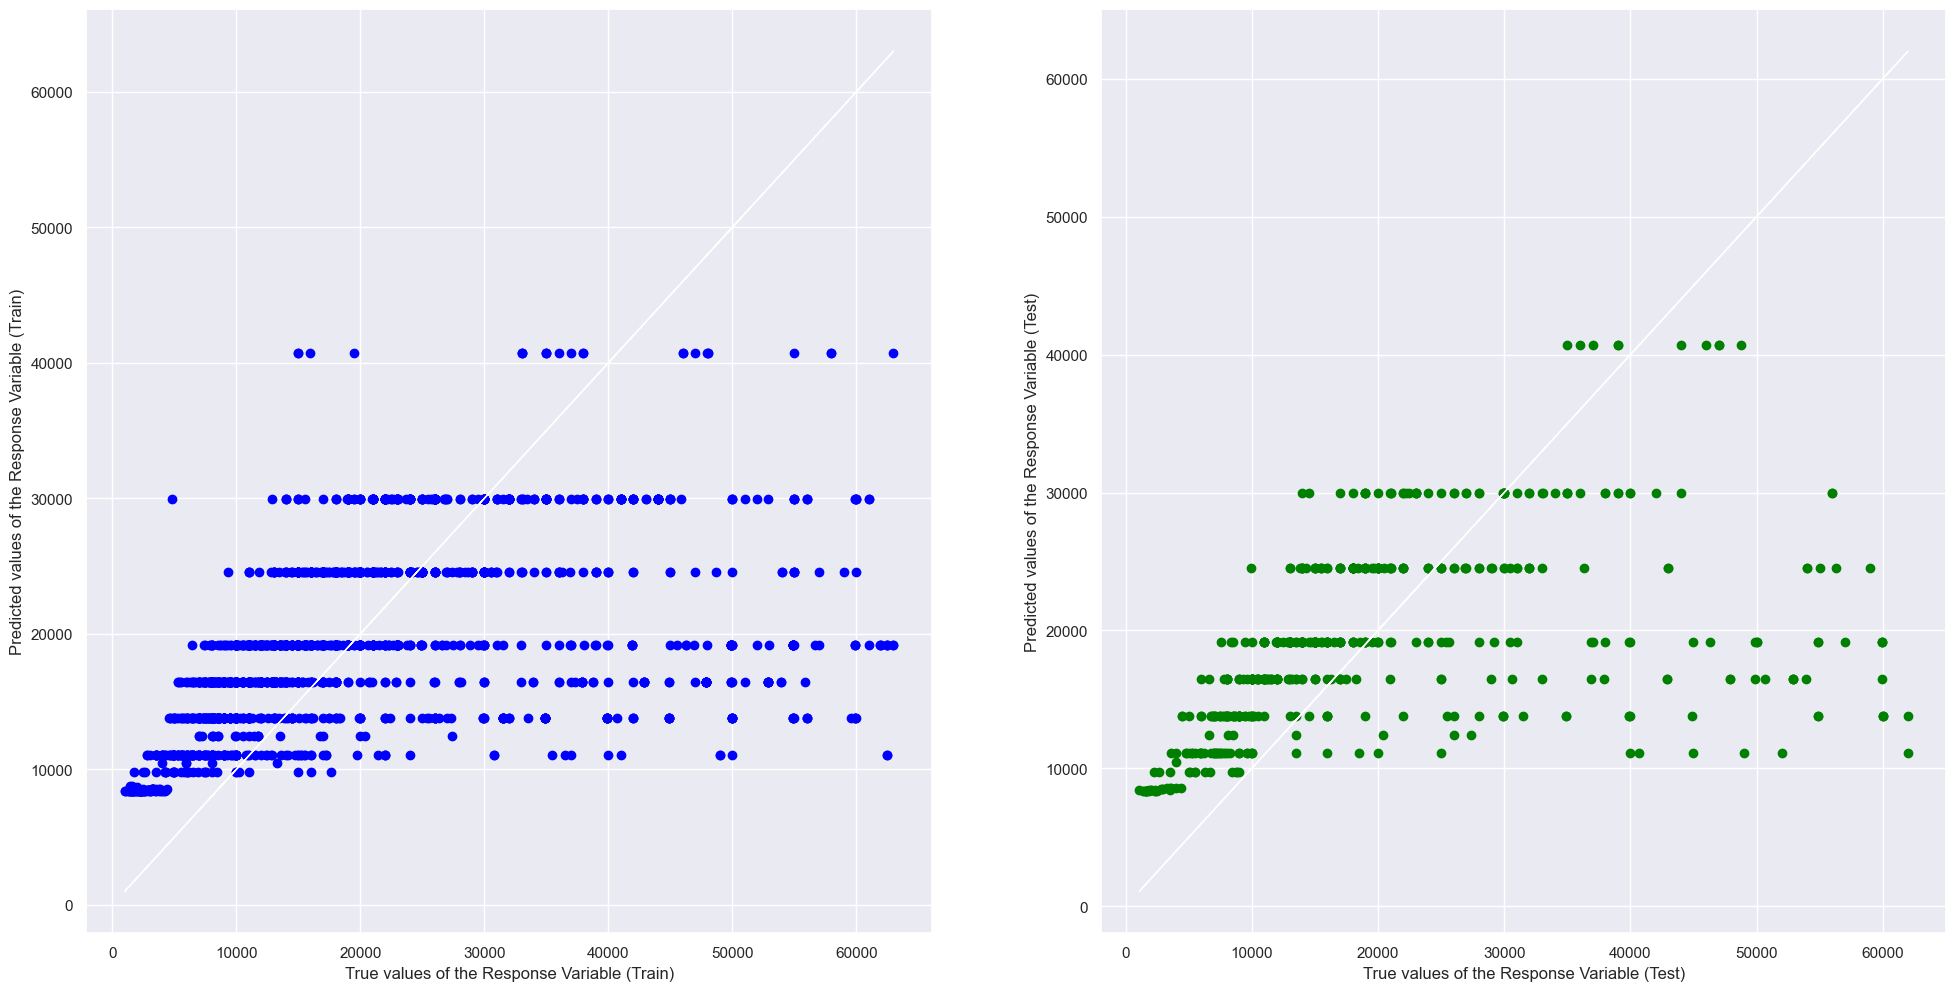

In [21]:
#Goodness of Fit of the model for the train set
originalPrice_test_pred = linreg.predict(memory_test)
originalPrice_train_pred = linreg.predict(memory_train)


#Goodness of Fit (on Train data)
print("Goodness of Fit of the Model Train Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(memory_train, originalPrice_train)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_train, originalPrice_train_pred)))
print()

#Goodness of Fit (on Test Data)
print("Goodness of Fit of the Model Test Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(memory_test, originalPrice_test)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_test, originalPrice_test_pred)))


#Plot the predictions vs the true values
f, axes = plt.subplots(1,2, figsize=(24,12))
axes[0].scatter(originalPrice_train, originalPrice_train_pred, color='blue')
axes[0].plot(originalPrice_train, originalPrice_train, 'w-', linewidth=1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")


axes[1].scatter(originalPrice_test, originalPrice_test_pred, color='green')
axes[1].plot(originalPrice_test, originalPrice_test, 'w-', linewidth=1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")

Coefficients of Regression: 20788.563329523735
Intercept of Regression: -68446.9521430005


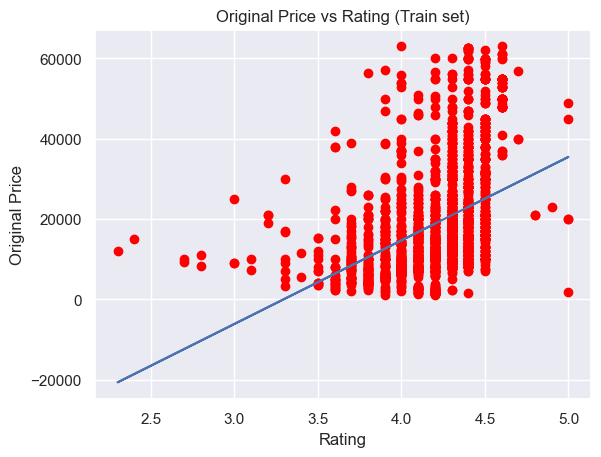

In [22]:
#Linear  Regression
rating = filtered_data[['Rating']] #Predictor
originalPrice = filtered_data['Original Price'] #Response

#Split the dataset into training and test set (80:20)
rating_train, rating_test, originalPrice_train, originalPrice_test = train_test_split(rating, originalPrice, test_size = 0.2)


#Fit linear regression into the training set
linreg = LinearRegression()
linreg.fit(rating_train, originalPrice_train)
print("Coefficients of Regression: {}".format(linreg.coef_[0])) 
print("Intercept of Regression: {}".format(linreg.intercept_)) 

#Plot the regression line
plt.scatter(rating_train, originalPrice_train, color='red')
plt.plot(rating_train, linreg.predict(rating_train))
plt.title("Original Price vs Rating (Train set)")
plt.xlabel('Rating')
plt.ylabel('Original Price')
plt.show()

Goodness of Fit of the Model Train Dataset
Explained Variance (R^2): 0.17255623601355552
Mean Squared Error (MSE): 145894304.4422944

Goodness of Fit of the Model Test Dataset
Explained Variance (R^2): 0.18199301956396174
Mean Squared Error (MSE): 140907014.02013183


Text(0, 0.5, 'Predicted values of the Response Variable (Test)')

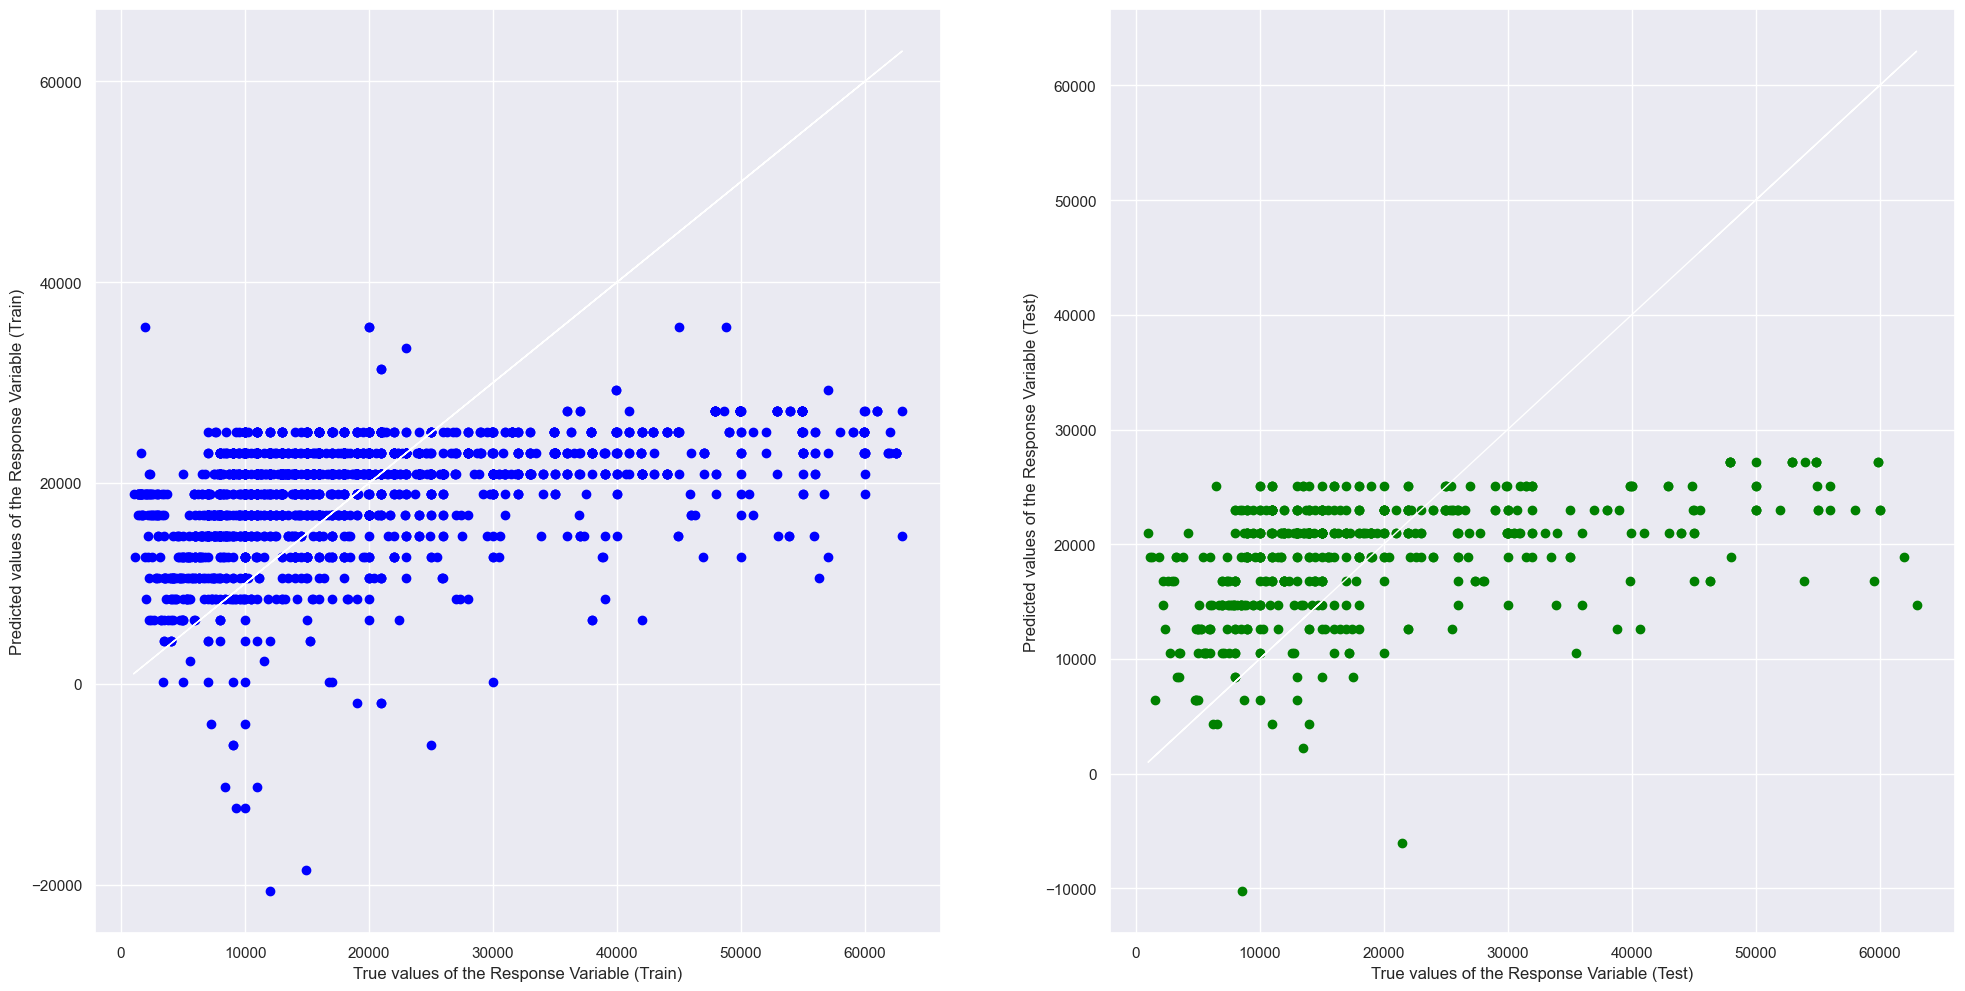

In [23]:
#Goodness of Fit of the model for the train set
originalPrice_test_pred = linreg.predict(rating_test)
originalPrice_train_pred = linreg.predict(rating_train)


#Goodness of Fit (on Train data)
print("Goodness of Fit of the Model Train Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(rating_train, originalPrice_train)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_train, originalPrice_train_pred)))
print()

#Goodness of Fit (on Test Data)
print("Goodness of Fit of the Model Test Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(rating_test, originalPrice_test)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_test, originalPrice_test_pred)))


#Plot the predictions vs the true values
f, axes = plt.subplots(1,2, figsize=(24,12))
axes[0].scatter(originalPrice_train, originalPrice_train_pred, color='blue')
axes[0].plot(originalPrice_train, originalPrice_train, 'w-', linewidth=1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")


axes[1].scatter(originalPrice_test, originalPrice_test_pred, color='green')
axes[1].plot(originalPrice_test, originalPrice_test, 'w-', linewidth=1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")

Now, lets investigate whether there is perhaps a mutual relationship between brand and original price 

<Axes: xlabel='Original Price', ylabel='Brands'>

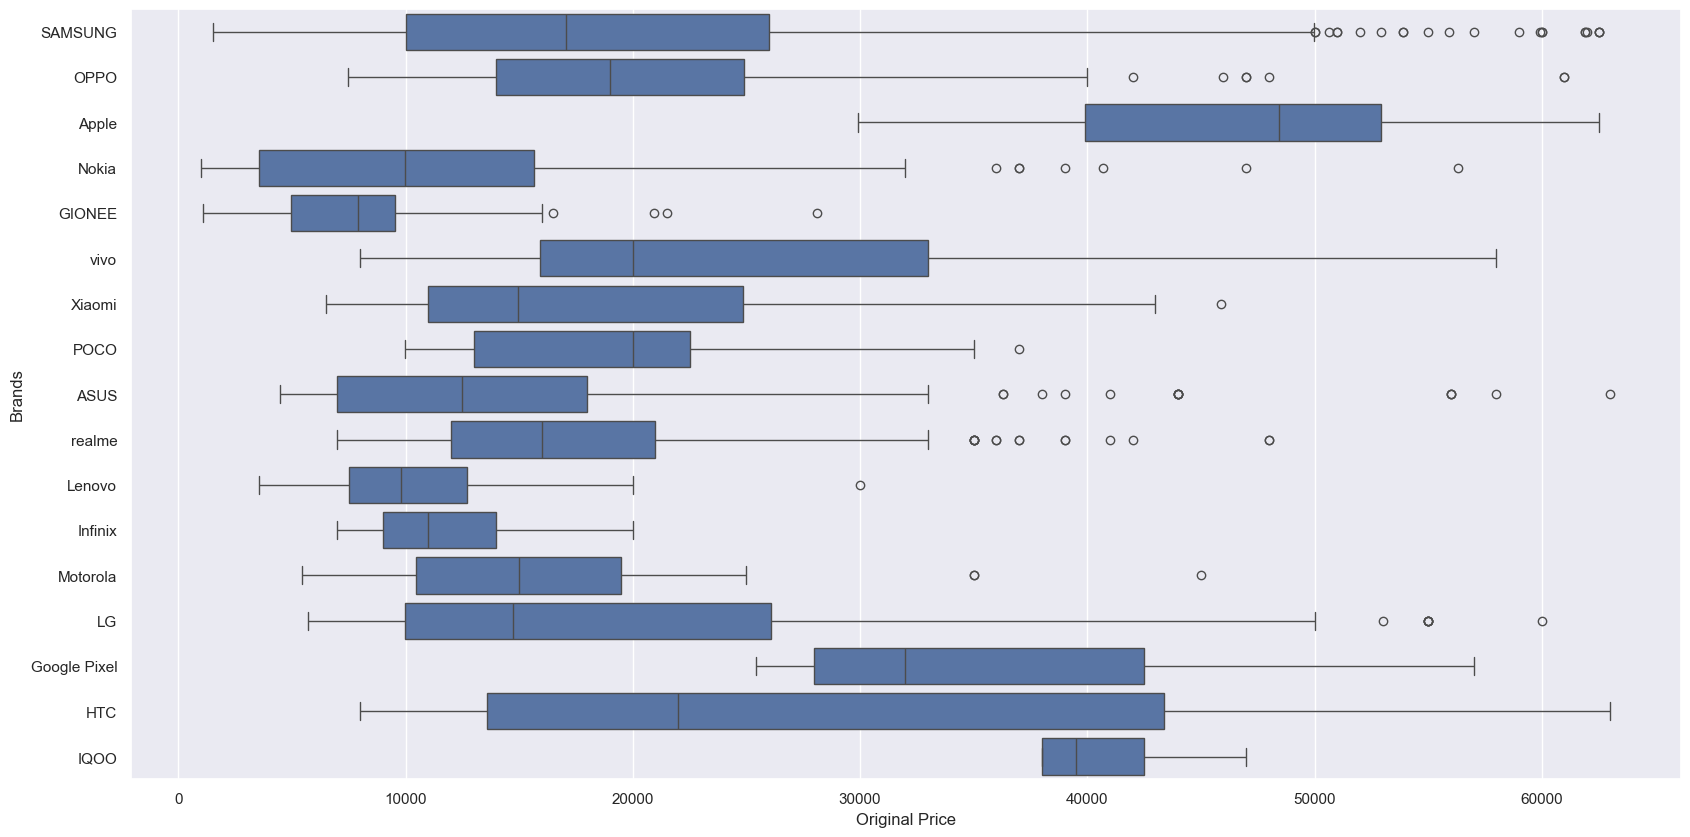

In [24]:
originalPrice = pd.DataFrame(filtered_data['Original Price'])
brands = pd.DataFrame(filtered_data['Brands'])

originalPrice_train, originalPrice_test, brands_train, brands_test = train_test_split(originalPrice, brands, test_size = 0.2)

joint = pd.concat([originalPrice_train, brands_train], axis=1).reindex(originalPrice_train.index)

f = plt.figure(figsize=(20,10))
sb.boxplot(x="Original Price", y="Brands", data = joint, orient="h")

In [25]:
#Function to split datapoints into 2 categories 

bins = [0, 30000, 70000]
labels = ["<= 30000", ">30000"]

filtered_data["Original Price"] = pd.cut(filtered_data["Original Price"], bins=bins, labels=labels)
filtered_data.head()

,Brands,Models,Colors,Memory,Storage,Camera,Rating,Selling Price,Original Price,Mobile,Discount,discount percentage
0,SAMSUNG,GALAXY M31S,Mirage Black,8.000,128.000,Yes,4.3,19330,<= 30000,SAMSUNG GALAXY M31S,1669,7.947998
1,Nokia,3.2,Steel,2.000,16.000,Yes,3.8,10199,<= 30000,Nokia 3.2,0,0.000000
3,Infinix,Note 5,Ice Blue,4.000,64.000,Yes,4.2,12999,<= 30000,Infinix Note 5,0,0.000000
4,Apple,iPhone 11,Black,4.000,64.000,Yes,4.6,49900,>30000,Apple iPhone 11,0,0.000000
5,GIONEE,L800,Black,0.008,0.016,Yes,4.0,2199,<= 30000,GIONEE L800,0,0.000000


# Create a Classification Model

Let's start by encoding the levels of our categorical predictor variable ("Brands") as integers. We will do so by encoding the unordered categorical variable by integers. This method is OneHotEncoding from the sklearn preprocessing module.

In [26]:
# Import the encoder from sklearn
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

# OneHotEncoding of categorical predictors (not the response)
predictor_variable_cat = filtered_data[['Brands']]
ohe.fit(predictor_variable_cat)
predictor_variable_cat_ohe = pd.DataFrame(ohe.transform(predictor_variable_cat).toarray(), 
                                  columns=ohe.get_feature_names_out(predictor_variable_cat.columns))

# Check the encoded variables 
predictor_variable_cat_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2625 entries, 0 to 2624
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brands_ASUS          2625 non-null   float64
 1   Brands_Apple         2625 non-null   float64
 2   Brands_GIONEE        2625 non-null   float64
 3   Brands_Google Pixel  2625 non-null   float64
 4   Brands_HTC           2625 non-null   float64
 5   Brands_IQOO          2625 non-null   float64
 6   Brands_Infinix       2625 non-null   float64
 7   Brands_LG            2625 non-null   float64
 8   Brands_Lenovo        2625 non-null   float64
 9   Brands_Motorola      2625 non-null   float64
 10  Brands_Nokia         2625 non-null   float64
 11  Brands_OPPO          2625 non-null   float64
 12  Brands_POCO          2625 non-null   float64
 13  Brands_SAMSUNG       2625 non-null   float64
 14  Brands_Xiaomi        2625 non-null   float64
 15  Brands_realme        2625 non-null   f

In [27]:
# Combining Numeric features with the OHE Categorical features
filtered_data_num = filtered_data[['Memory','Storage','Rating']]
filtered_data_response = filtered_data['Original Price']

filtered_data_ohe = pd.concat([filtered_data_num, filtered_data_response ,predictor_variable_cat_ohe], 
                           sort = False, axis = 1).reindex(index=filtered_data_num.index)

# Check the final dataframe
filtered_data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2625 entries, 0 to 3113
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Memory               2625 non-null   float64 
 1   Storage              2625 non-null   float64 
 2   Rating               2625 non-null   float64 
 3   Original Price       2625 non-null   category
 4   Brands_ASUS          2212 non-null   float64 
 5   Brands_Apple         2212 non-null   float64 
 6   Brands_GIONEE        2212 non-null   float64 
 7   Brands_Google Pixel  2212 non-null   float64 
 8   Brands_HTC           2212 non-null   float64 
 9   Brands_IQOO          2212 non-null   float64 
 10  Brands_Infinix       2212 non-null   float64 
 11  Brands_LG            2212 non-null   float64 
 12  Brands_Lenovo        2212 non-null   float64 
 13  Brands_Motorola      2212 non-null   float64 
 14  Brands_Nokia         2212 non-null   float64 
 15  Brands_OPPO          2212 

### Create and Fit the Model

Now, after the encoding is done, we can create and fit the `DecisionTreeClassifier` model on the dataset.

[Text(0.5446428571428571, 0.9, 'Rating <= 4.45\ngini = 0.283\nsamples = 2100\nvalue = [1742, 358]\nclass = <=30000'),
 Text(0.2857142857142857, 0.7, 'Memory <= 7.0\ngini = 0.205\nsamples = 1835\nvalue = [1622, 213]\nclass = <=30000'),
 Text(0.14285714285714285, 0.5, 'Storage <= 24.0\ngini = 0.137\nsamples = 1628\nvalue = [1508, 120]\nclass = <=30000'),
 Text(0.07142857142857142, 0.3, 'Rating <= 4.35\ngini = 0.029\nsamples = 471\nvalue = [464, 7]\nclass = <=30000'),
 Text(0.03571428571428571, 0.1, 'gini = 0.004\nsamples = 456\nvalue = [455, 1]\nclass = <=30000'),
 Text(0.10714285714285714, 0.1, 'gini = 0.48\nsamples = 15\nvalue = [9, 6]\nclass = <=30000'),
 Text(0.21428571428571427, 0.3, 'Memory <= 1.5\ngini = 0.176\nsamples = 1157\nvalue = [1044, 113]\nclass = <=30000'),
 Text(0.17857142857142858, 0.1, 'gini = 0.459\nsamples = 14\nvalue = [9, 5]\nclass = <=30000'),
 Text(0.25, 0.1, 'gini = 0.171\nsamples = 1143\nvalue = [1035, 108]\nclass = <=30000'),
 Text(0.42857142857142855, 0.5, 'S

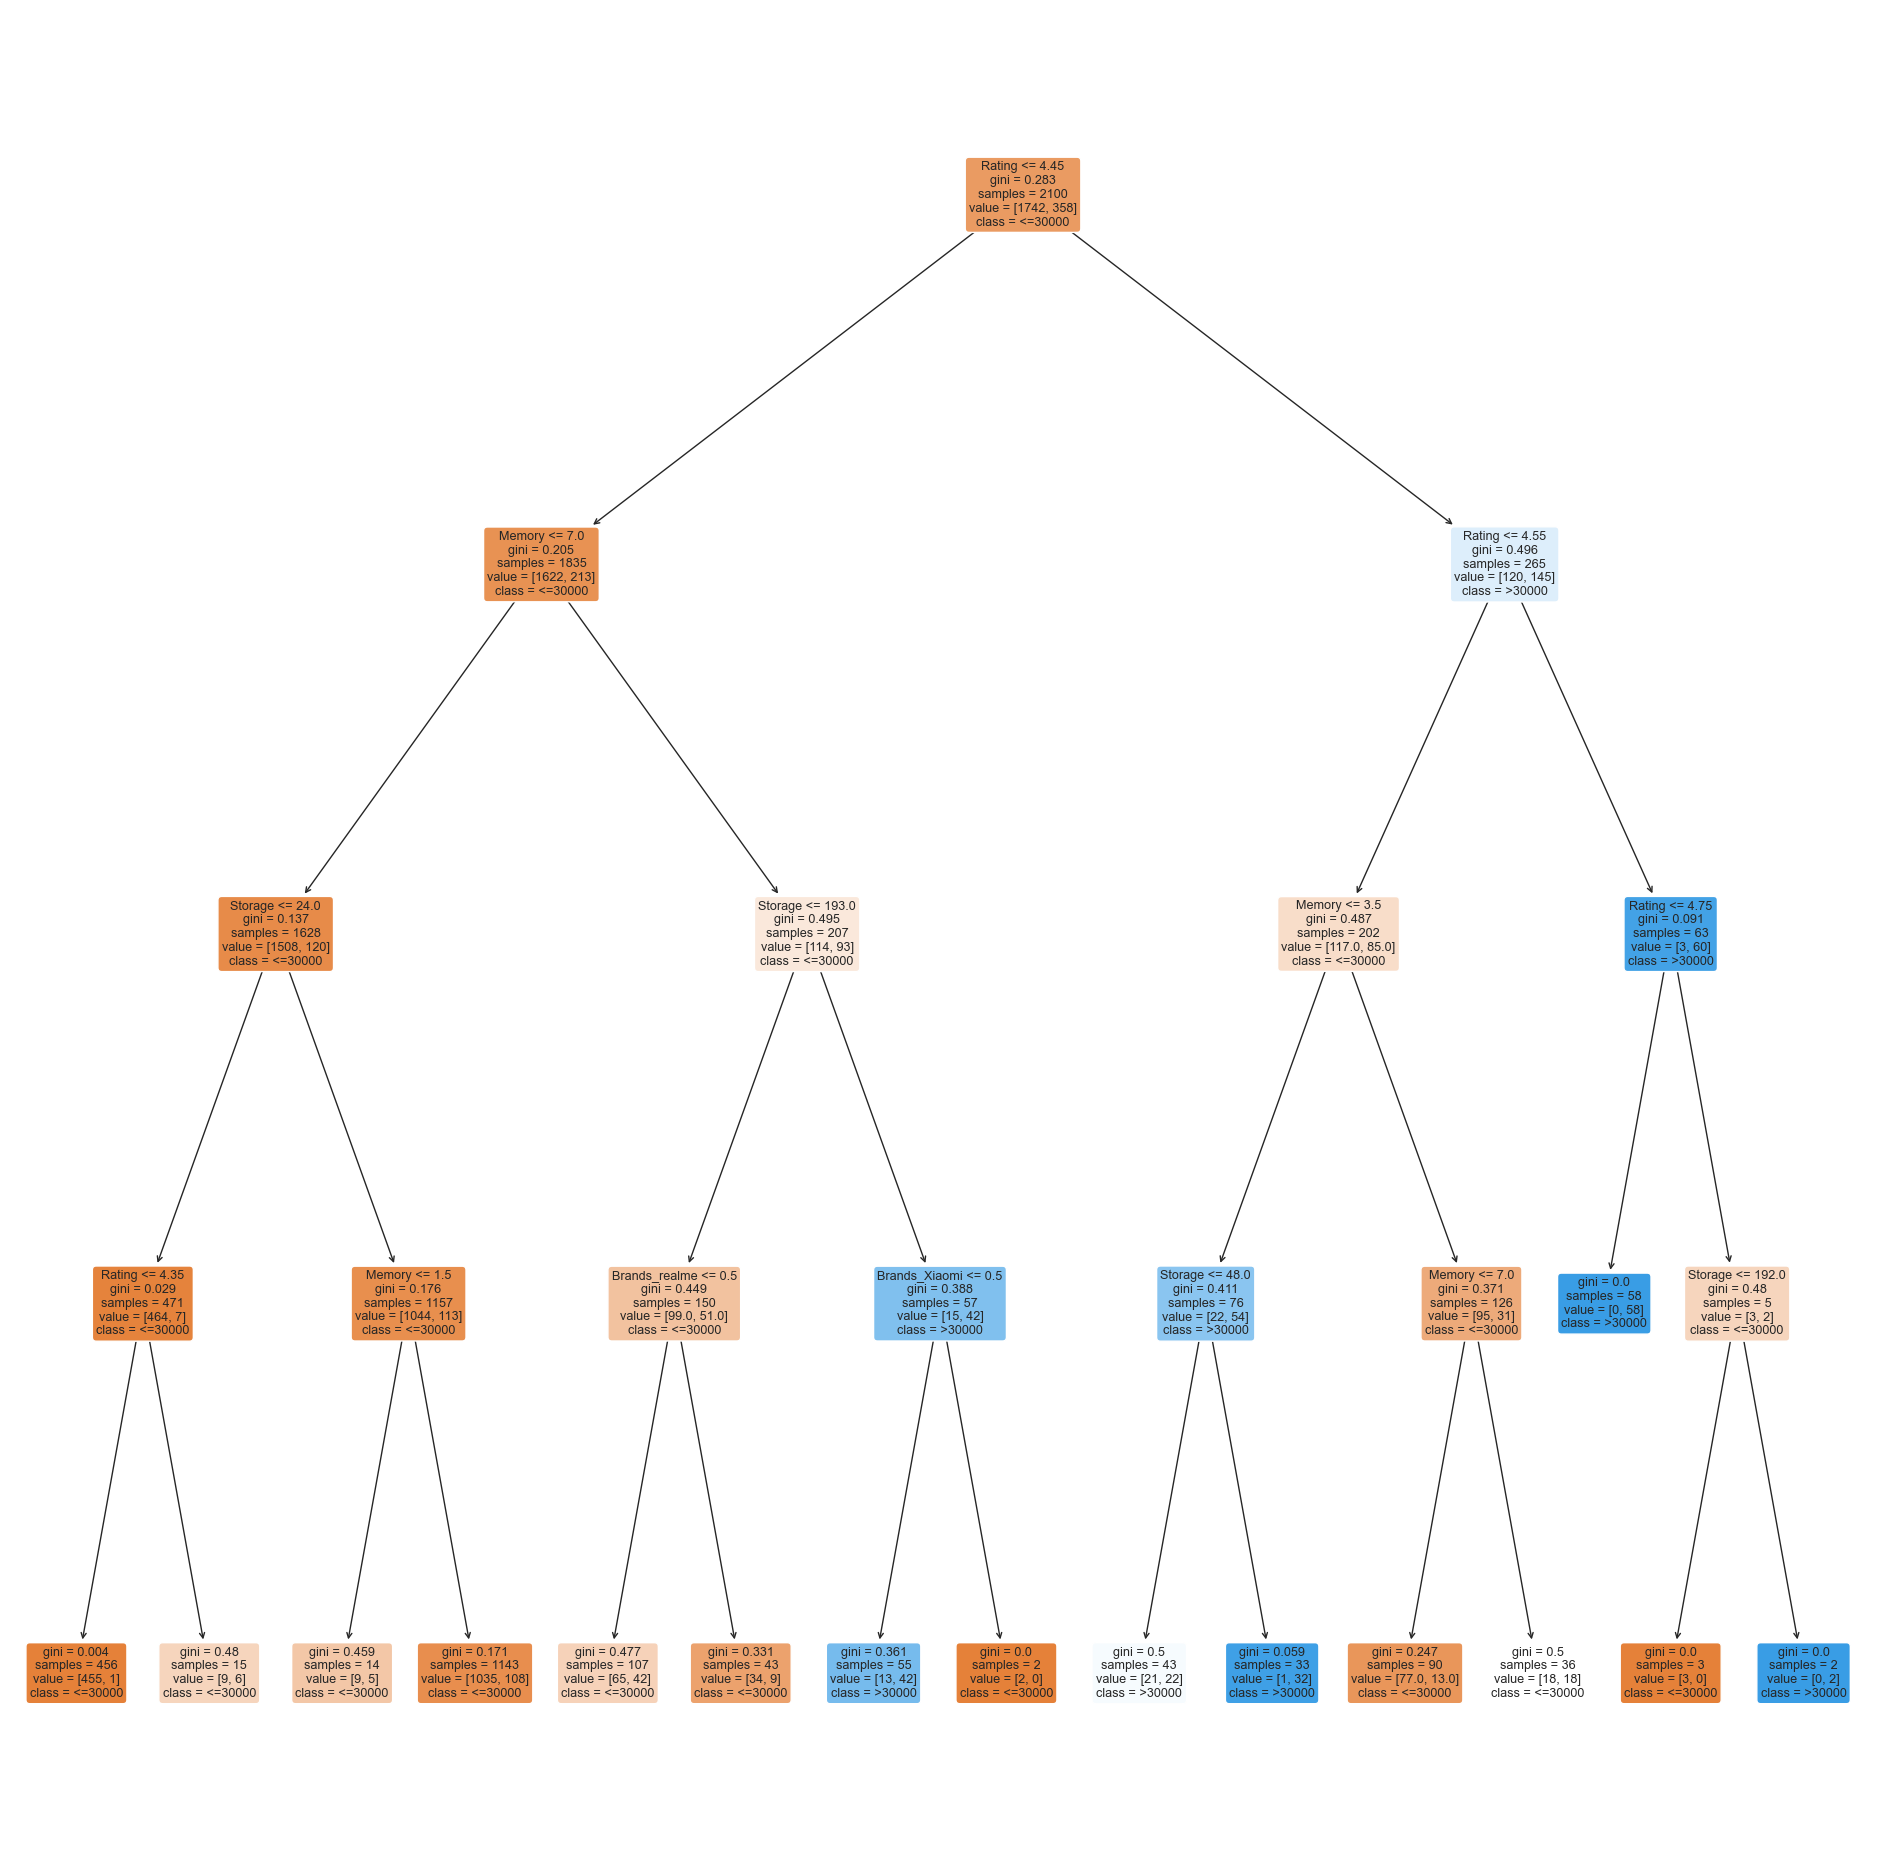

In [28]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

# Extract Response and Predictors
y = pd.DataFrame(filtered_data_ohe['Original Price'])
X = pd.DataFrame(filtered_data_ohe.drop('Original Price', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # change max_depth to experiment
dectree.fit(X_train, y_train)                    # train the decision tree model

# Plot the trained Decision Tree
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["<=30000",">30000"])

Train Data
Accuracy  :	 0.8871428571428571

TPR Train :	 0.43575418994413406
TNR Train :	 0.9799081515499426

FPR Train :	 0.020091848450057407
FNR Train :	 0.5642458100558659


<Axes: >

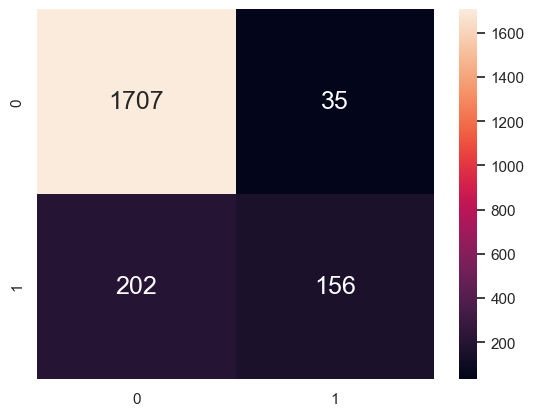

In [29]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# Refining the Model

Let's refine the previous model by balancing the classes of the response `Original Price` in the training data. Keeping the OneHotEncoding same as before.

In [30]:
# Upsample >30000 to match <=30000
from sklearn.utils import resample

data_high_price = filtered_data_ohe[filtered_data_ohe["Original Price"] == ">30000"]
data_low_price = filtered_data_ohe[filtered_data_ohe["Original Price"] == "<= 30000"]
 
# Upsample the Bad samples
data_high_price_up = resample(data_high_price, 
                        replace=True,                         # sample with replacement
                        n_samples=data_low_price.shape[0])    # to match number of samples <=30000
 
# Combine the two classes back after upsampling
data_ohe_up = pd.concat([data_high_price_up, data_low_price])
 
# Check the ratio of the classes
data_ohe_up['Original Price'].value_counts()

Original Price
<= 30000    2181
>30000      2181
Name: count, dtype: int64

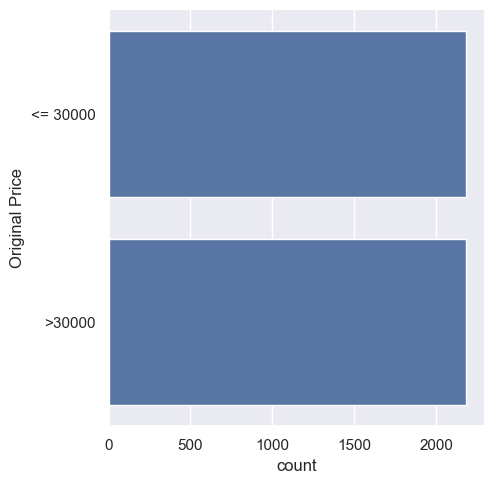

In [31]:
# Quick plot to check the balanced classes visually
sb.catplot(y = 'Original Price', data = data_ohe_up, kind = "count")

In [32]:
# Confirm that the OHE is still in place
# and that the samples have now increased
data_ohe_up.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4362 entries, 1063 to 3113
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Memory               4362 non-null   float64 
 1   Storage              4362 non-null   float64 
 2   Rating               4362 non-null   float64 
 3   Original Price       4362 non-null   category
 4   Brands_ASUS          3687 non-null   float64 
 5   Brands_Apple         3687 non-null   float64 
 6   Brands_GIONEE        3687 non-null   float64 
 7   Brands_Google Pixel  3687 non-null   float64 
 8   Brands_HTC           3687 non-null   float64 
 9   Brands_IQOO          3687 non-null   float64 
 10  Brands_Infinix       3687 non-null   float64 
 11  Brands_LG            3687 non-null   float64 
 12  Brands_Lenovo        3687 non-null   float64 
 13  Brands_Motorola      3687 non-null   float64 
 14  Brands_Nokia         3687 non-null   float64 
 15  Brands_OPPO          36

[Text(0.5446428571428571, 0.9, 'Rating <= 4.35\ngini = 0.5\nsamples = 3489\nvalue = [1757, 1732]\nclass = <=30000'),
 Text(0.2857142857142857, 0.7, 'Storage <= 96.0\ngini = 0.433\nsamples = 1954\nvalue = [1335, 619]\nclass = <=30000'),
 Text(0.14285714285714285, 0.5, 'Storage <= 24.0\ngini = 0.276\nsamples = 1292\nvalue = [1078, 214]\nclass = <=30000'),
 Text(0.07142857142857142, 0.3, 'Brands_Infinix <= 0.5\ngini = 0.022\nsamples = 460\nvalue = [455, 5]\nclass = <=30000'),
 Text(0.03571428571428571, 0.1, 'gini = 0.009\nsamples = 439\nvalue = [437, 2]\nclass = <=30000'),
 Text(0.10714285714285714, 0.1, 'gini = 0.245\nsamples = 21\nvalue = [18, 3]\nclass = <=30000'),
 Text(0.21428571428571427, 0.3, 'Rating <= 4.25\ngini = 0.376\nsamples = 832\nvalue = [623, 209]\nclass = <=30000'),
 Text(0.17857142857142858, 0.1, 'gini = 0.457\nsamples = 554\nvalue = [358, 196]\nclass = <=30000'),
 Text(0.25, 0.1, 'gini = 0.089\nsamples = 278\nvalue = [265, 13]\nclass = <=30000'),
 Text(0.428571428571428

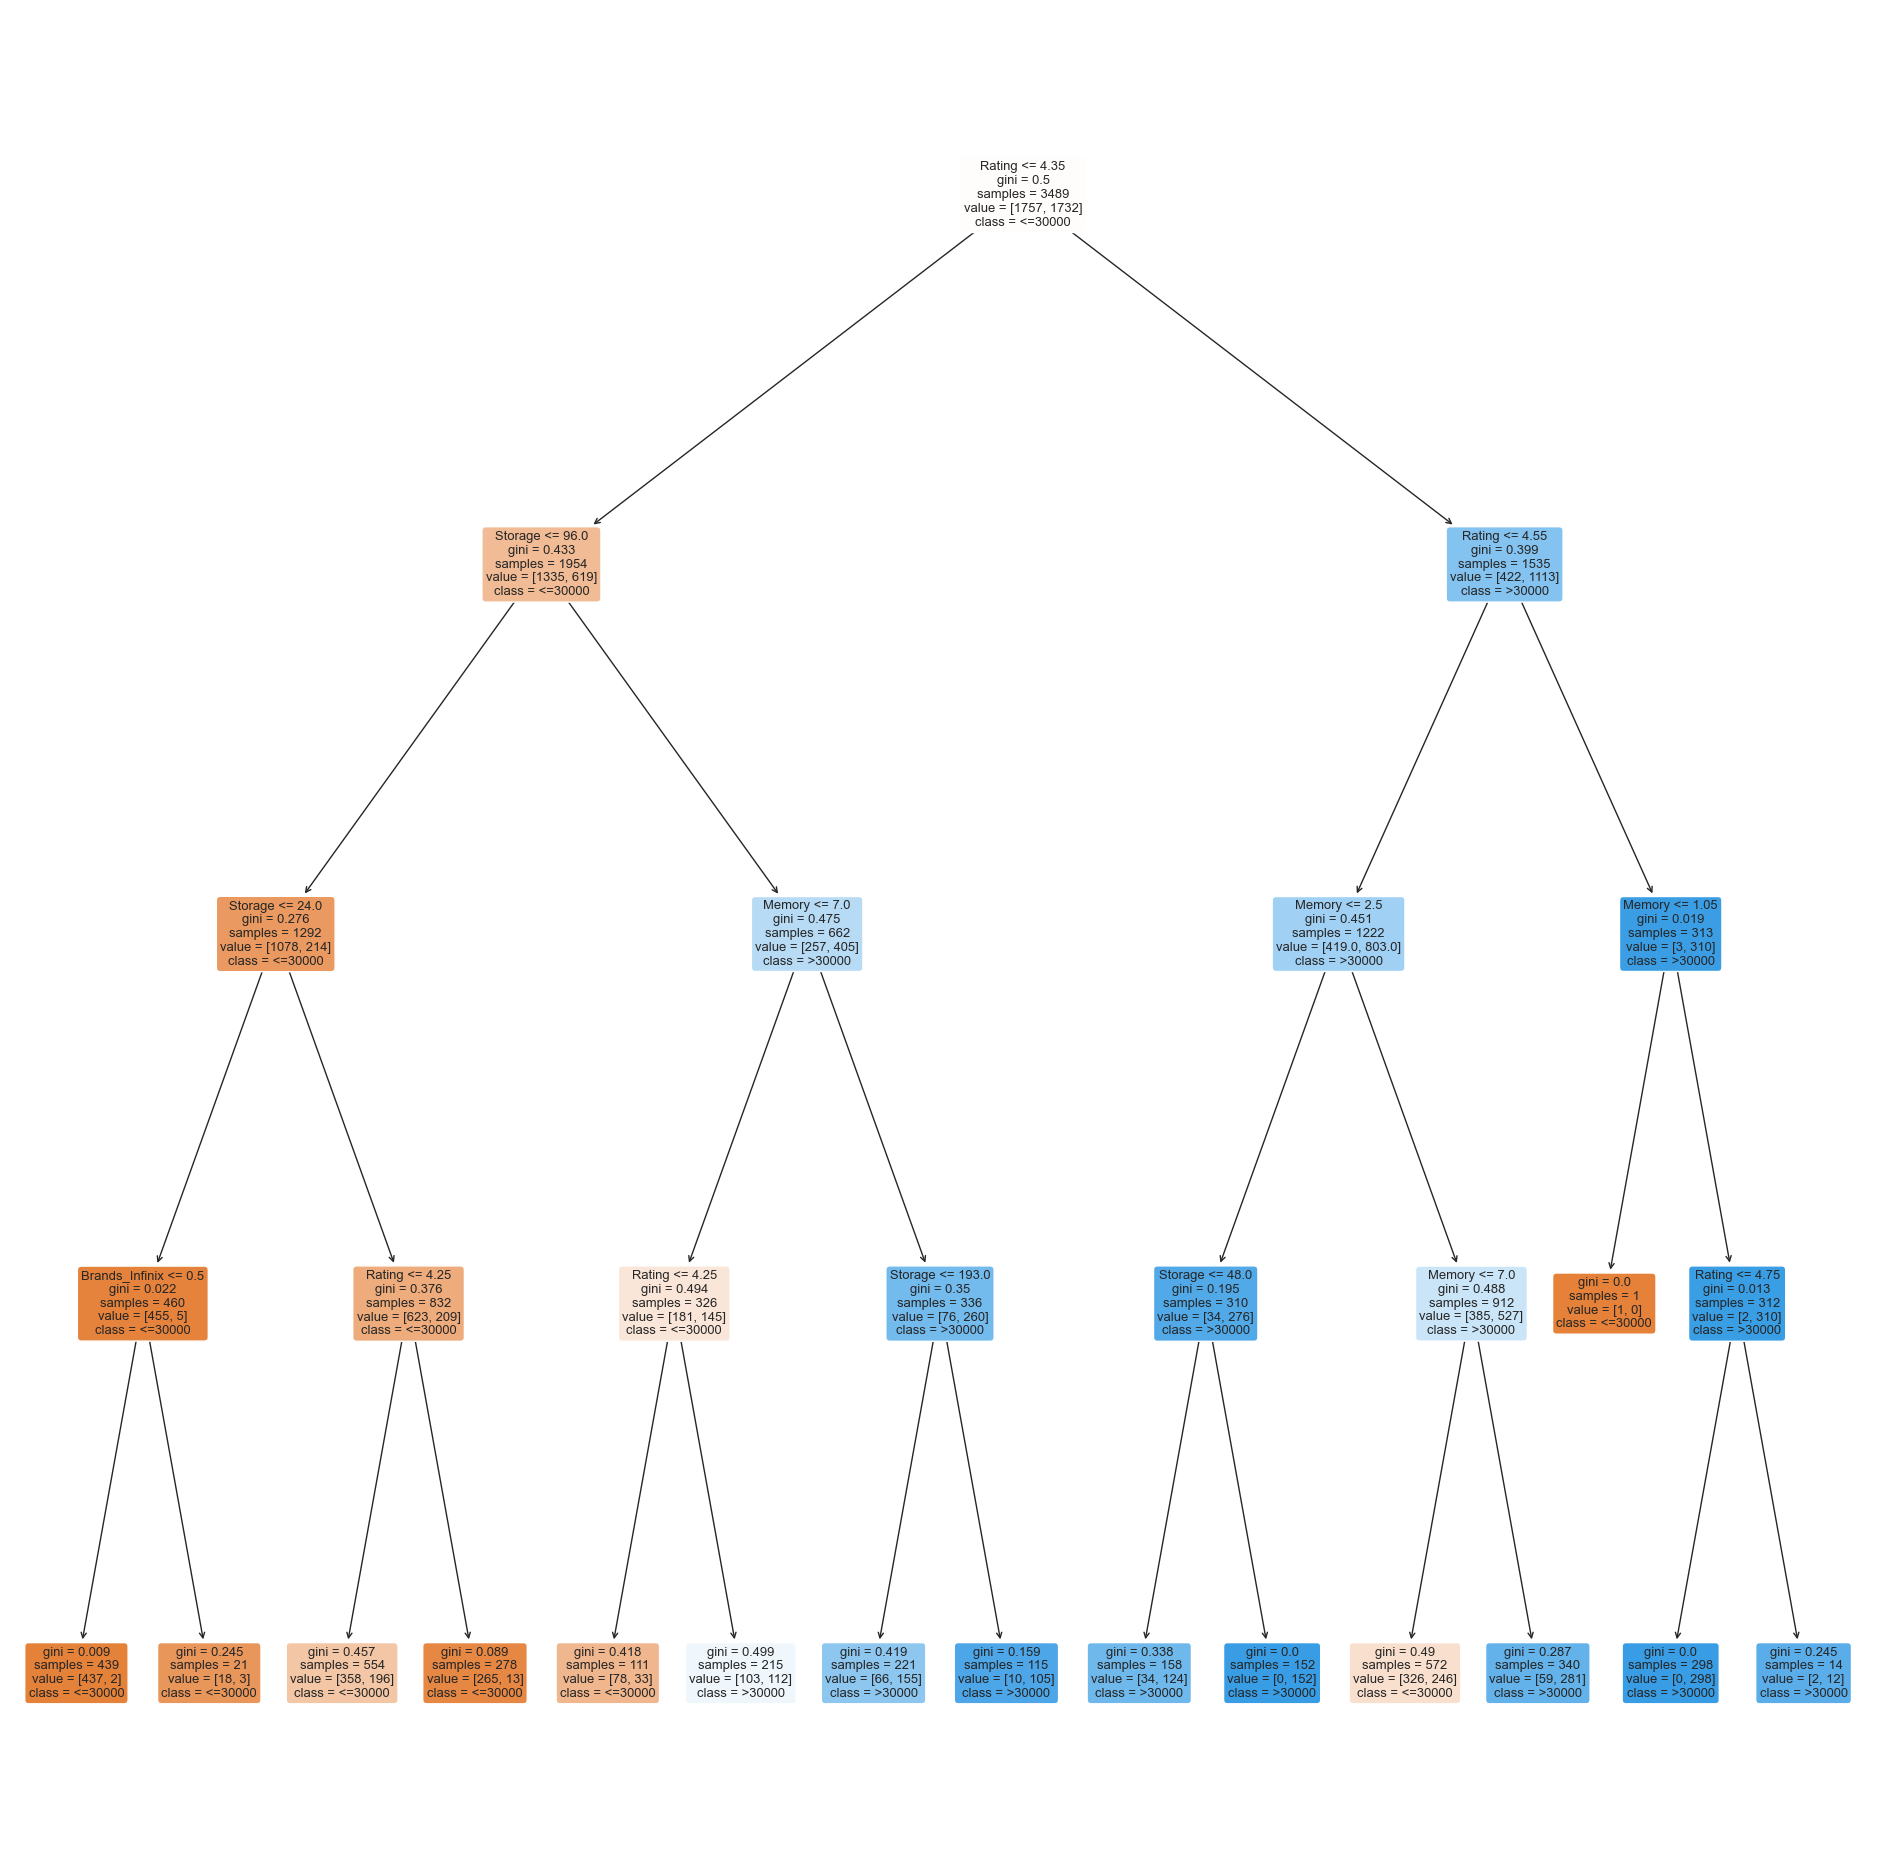

In [33]:
# Extract Response and Predictors
y = pd.DataFrame(data_ohe_up['Original Price'])
X = pd.DataFrame(data_ohe_up.drop('Original Price', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # change max_depth to experiment
dectree.fit(X_train, y_train)                    # train the decision tree model

# Plot the trained Decision Tree
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["<=30000",">30000"])

Train Data
Accuracy  :	 0.7801662367440527

TPR Train :	 0.7153579676674365
TNR Train :	 0.8440523619806488

FPR Train :	 0.15594763801935116
FNR Train :	 0.2846420323325635


<Axes: >

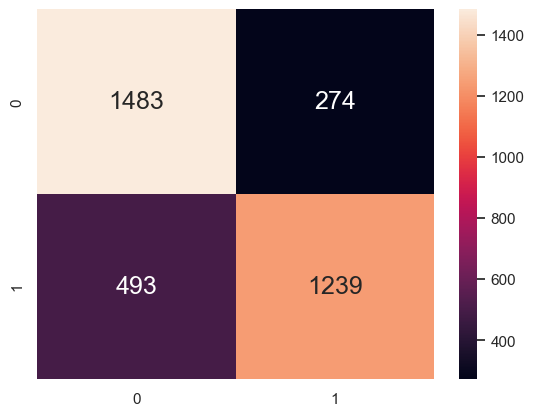

In [34]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.7571592210767468

TPR Test :	 0.6859688195991092
TNR Test :	 0.8325471698113207

FPR Test :	 0.16745283018867924
FNR Test :	 0.31403118040089084


<Axes: >

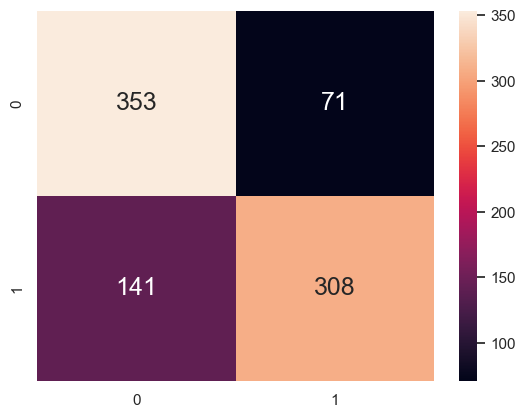

In [35]:
# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", dectree.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# Further refinement of Prediction Model

Using an ensemble of trees for better classification, tree based classifier -- `RandomForest`

In [36]:
# Extract Response and Predictors
y = pd.DataFrame(data_ohe_up['Original Price'])
X = pd.DataFrame(data_ohe_up.drop('Original Price', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 100,  # n_estimators denote number of trees
                                 max_depth = 4)       # set the maximum depth of each tree

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train['Original Price'].to_numpy())

RandomForestClassifier(max_depth=4)

Train Data
Accuracy  :	 0.7738607050730868

TPR Train :	 0.7021276595744681
TNR Train :	 0.8451428571428572

FPR Train :	 0.15485714285714286
FNR Train :	 0.2978723404255319


<Axes: >

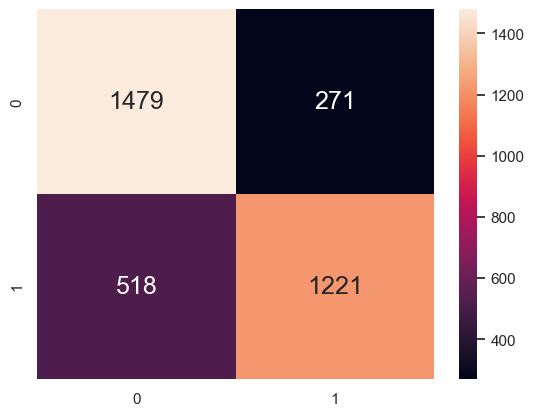

In [37]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.7823596792668958

TPR Test :	 0.7375565610859729
TNR Test :	 0.8283062645011601

FPR Test :	 0.1716937354988399
FNR Test :	 0.26244343891402716


<Axes: >

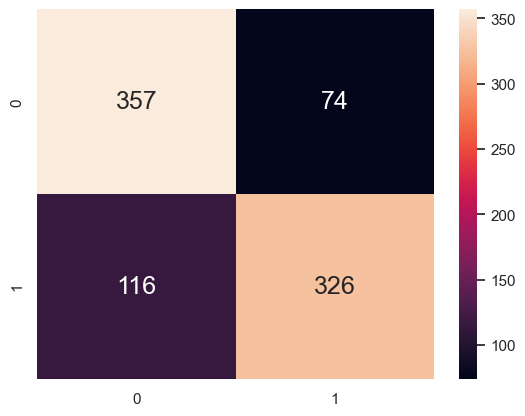

In [38]:
# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", dectree.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

### Using GridSearch

In [39]:
# Extract Response and Predictors
y = pd.DataFrame(data_ohe_up['Original Price'])
X = pd.DataFrame(data_ohe_up.drop('Original Price', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [40]:
# Import GridSearch for hyperparameter tuning using Cross-Validation (CV)
from sklearn.model_selection import GridSearchCV

# Define the Hyper-parameter Grid to search on, in case of Random Forest
param_grid = {'n_estimators': np.arange(100,1001,100),   # number of trees 100, 200, ..., 1000
              'max_depth': np.arange(2, 11)}             # depth of trees 2, 3, 4, 5, ..., 10

# Create the Hyper-parameter Grid
hpGrid = GridSearchCV(RandomForestClassifier(),   # the model family
                      param_grid,                 # the search grid
                      cv = 5,                     # 5-fold cross-validation
                      scoring = 'accuracy')       # score to evaluate

# Train the models using Cross-Validation
hpGrid.fit(X_train, y_train['Original Price'].to_numpy())
# hpGrid.fit(X_train, y_train['Original Price'].ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
             scoring='accuracy')

In [41]:
# Fetch the best Model or the best set of Hyper-parameters
print(hpGrid.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(hpGrid.best_score_))

RandomForestClassifier(max_depth=10, n_estimators=1000)
0.8308991050470087


### Use the Best Model found through GridSearchCV

In [42]:
# Extract Response and Predictors
y = pd.DataFrame(data_ohe_up['Original Price'])
X = pd.DataFrame(data_ohe_up.drop('Original Price', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 200,   # found using GridSearchCV
                                 max_depth = 10)       # found using GridSearchCV

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train["Original Price"].to_numpy())

RandomForestClassifier(max_depth=10, n_estimators=200)

Train Data
Accuracy  :	 0.8618515333906563

TPR Train :	 0.8489042675893888
TNR Train :	 0.8746438746438746

FPR Train :	 0.12535612535612536
FNR Train :	 0.1510957324106113


<Axes: >

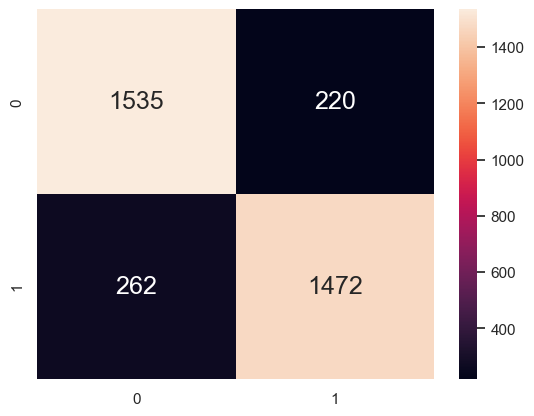

In [43]:
# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.827033218785796

TPR Test :	 0.8366890380313199
TNR Test :	 0.8169014084507042

FPR Test :	 0.18309859154929578
FNR Test :	 0.16331096196868009


<Axes: >

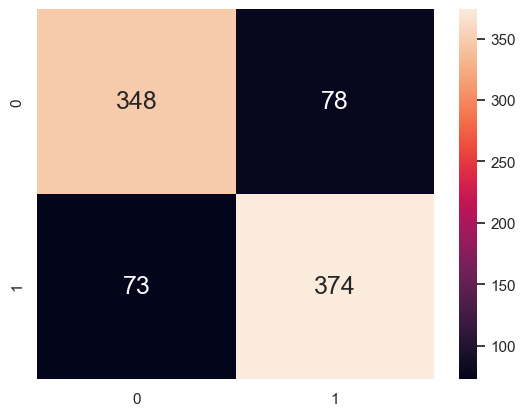

In [44]:
# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

## Multi-Variate Linear Regression

We will start by setting up a Multi-Variate Linear Regression problem. 

Response Variable : **Original Price**     
Predictor Feature : **Memory, Storage, Rating**       

> Regression Model : Total = $a_1$ $\times$ Memory + $a_2$ $\times$ Storage + $a_3$ $\times$ Rating + $b$  

Extract the variables and the associated data as a Pandas `DataFrame`.

In [45]:
#Create a new dataframe
filtered_data_multi_var_linreg = pd.concat([filtered_data_num, originalPrice], 
                           sort = False, axis = 1).reindex(index=filtered_data_num.index)

print(filtered_data_multi_var_linreg)

      Memory  Storage  Rating  Original Price
0      8.000  128.000     4.3           20999
1      2.000   16.000     3.8           10199
3      4.000   64.000     4.2           12999
4      4.000   64.000     4.6           49900
5      0.008    0.016     4.0            2199
...      ...      ...     ...             ...
3107   0.512    4.000     4.0            5999
3108   0.004    0.002     4.2            2299
3109   6.000  128.000     4.4           19999
3111   2.000  128.000     4.5           44900
3113   3.000   32.000     4.2            7900

[2625 rows x 4 columns]


In [46]:
# Extract Response and Predictors
y = pd.DataFrame(filtered_data_multi_var_linreg["Original Price"])
X = pd.DataFrame(filtered_data_multi_var_linreg[["Memory", "Storage", "Rating"]])

# filtered_data_num = filtered_data[['Memory','Storage','Rating']]
# filtered_data_response = filtered_data['Original Price']

# y = filtered_data_num
# X = filtered_data_response

# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

Train Set : (2100, 1) (2100, 3)
Test Set  : (525, 1) (525, 3)


In [47]:
# Import LinearRegression model from Scikit-Learn
from sklearn.linear_model import LinearRegression


# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"])

Intercept of Regression 	: b =  [-35130.41172286]
Coefficients of Regression 	: a =  [[  169.61060559    93.64122997 11162.15769028]]



,Predictors,Coefficients
0,Memory,169.610606
1,Storage,93.641230
2,Rating,11162.157690


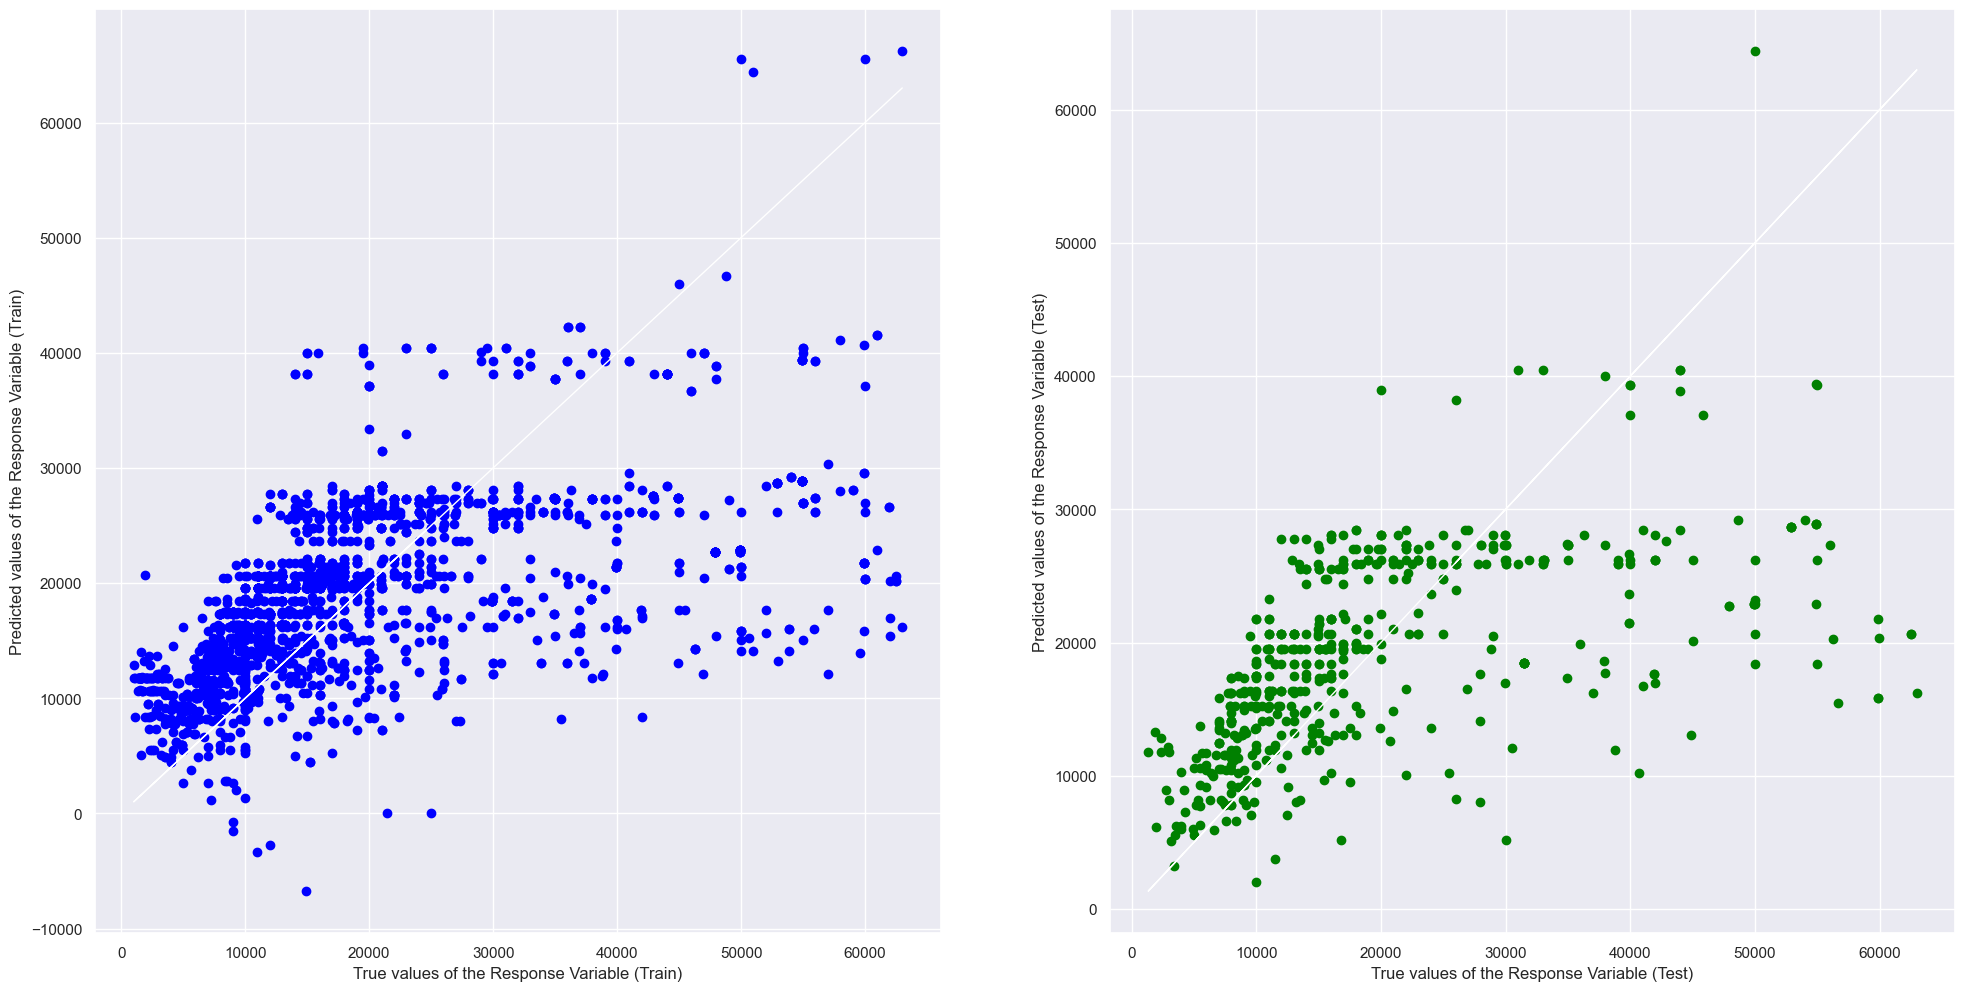

In [48]:
# Predict the Total values from Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

## Goodness of fit of the model

In [49]:
# Import mean_squared_error from sklearn
from sklearn.metrics import mean_squared_error

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.3424463260495143
Mean Squared Error (MSE) 	: 114490297.36574878

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.3208453861126006
Mean Squared Error (MSE) 	: 122667720.5570663



## Multi-Variate Linear Regression

We will now set up a Multi-Variate Linear Regression problem, with the inclusion of "Brands" as a numerically encoded predictor

Response Variable : **Original Price**     
Predictor Feature : **Memory, Storage, Rating, Brands**       

> Regression Model : Total = $a_1$ $\times$ Memory + $a_2$ $\times$ Storage + $a_3$ $\times$ Rating + $a_4$ $\times$ Brands + $b$  

Extract the variables and the associated data as a Pandas `DataFrame`.

In [50]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# Ordinal Encoding of categorical predictors 
predictor_variable_cat = filtered_data['Brands']
le.fit(predictor_variable_cat)
predictor_variable_cat_le = pd.DataFrame(le.transform(predictor_variable_cat))

In [51]:
#Create a new dataframe
filtered_data_le = pd.concat([filtered_data_num, originalPrice ,predictor_variable_cat_le], 
                           sort = False, axis = 1).reindex(index=filtered_data_num.index)

print(filtered_data_le)

      Memory  Storage  Rating  Original Price     0
0      8.000  128.000     4.3         20999.0  13.0
1      2.000   16.000     3.8         10199.0  10.0
3      4.000   64.000     4.2         12999.0   1.0
4      4.000   64.000     4.6         49900.0   2.0
5      0.008    0.016     4.0          2199.0   1.0
...      ...      ...     ...             ...   ...
3107   0.512    4.000     4.0          5999.0   NaN
3108   0.004    0.002     4.2          2299.0   NaN
3109   6.000  128.000     4.4         19999.0   NaN
3111   2.000  128.000     4.5         44900.0   NaN
3113   3.000   32.000     4.2          7900.0   NaN

[2625 rows x 5 columns]


In [52]:
# Extract Response and Predictors
y = pd.DataFrame(filtered_data_le['Original Price'])
X = pd.DataFrame(filtered_data_le.drop('Original Price', axis = 1))

# Convert all column names to string
X.columns = X.columns.astype(str)

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

Train Set : (2100, 1) (2100, 4)
Test Set  : (525, 1) (525, 4)


<Axes: >

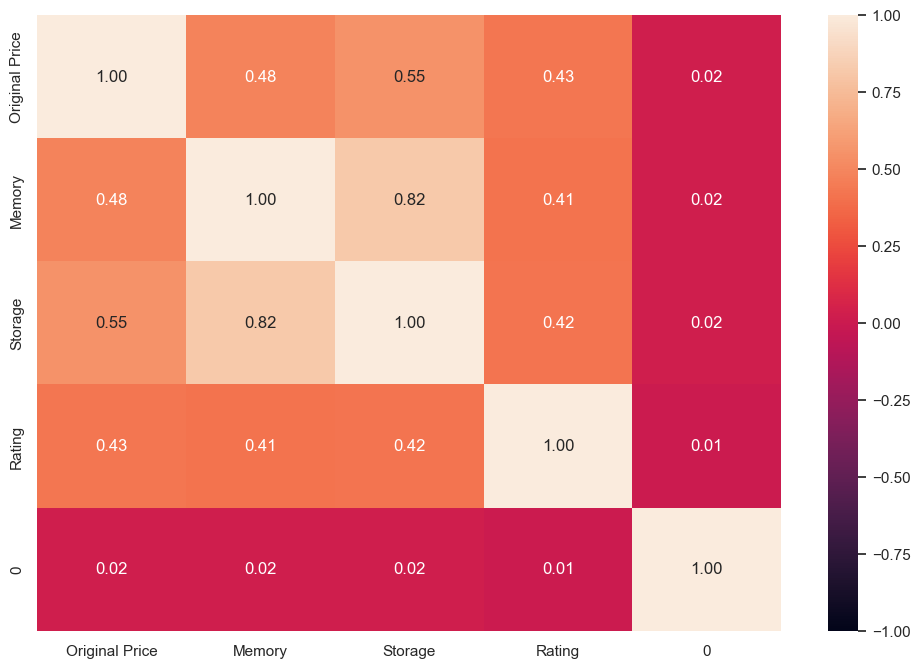

In [53]:
# Correlation between Response and the Predictors

# Convert all column names to string
X.columns = X.columns.astype(str)

trainDF = pd.concat([y_train, X_train], axis = 1).reindex(y_train.index)

f = plt.figure(figsize=(12, 8))
sb.heatmap(trainDF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

In [54]:
#Create a new dataframe
filtered_data_te = pd.concat([filtered_data_num, originalPrice ,brands], 
                           sort = False, axis = 1).reindex(index=filtered_data_num.index)

# Print dataframe before target encoding was applied to all predictor variables
print(filtered_data_te)

import numpy as np
from sklearn.preprocessing import TargetEncoder
filtered_data_te = filtered_data_te.dropna()
y = pd.DataFrame(filtered_data_te['Original Price'])

X = pd.DataFrame(filtered_data_te.drop('Original Price', axis = 1))

enc_high_smooth = TargetEncoder(target_type="continuous", smooth=5000.0).fit_transform(X, y)
enc_low_smooth = TargetEncoder(target_type="continuous",smooth=1.0).fit_transform(X, y)

      Memory  Storage  Rating  Original Price   Brands
0      8.000  128.000     4.3           20999  SAMSUNG
1      2.000   16.000     3.8           10199    Nokia
3      4.000   64.000     4.2           12999  Infinix
4      4.000   64.000     4.6           49900    Apple
5      0.008    0.016     4.0            2199   GIONEE
...      ...      ...     ...             ...      ...
3107   0.512    4.000     4.0            5999  SAMSUNG
3108   0.004    0.002     4.2            2299  SAMSUNG
3109   6.000  128.000     4.4           19999     POCO
3111   2.000  128.000     4.5           44900    Apple
3113   3.000   32.000     4.2            7900   GIONEE

[2625 rows x 5 columns]


/Users/wenjun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wenjun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [55]:
df_enc_low_smooth = pd.DataFrame(enc_low_smooth)

#Print dataframe after target encoding applied to all predictor variables
print(df_enc_low_smooth)

                 0             1             2             3
0     30607.301941  26797.380736  19382.958618  19071.365335
1     17585.775644  13128.671570  10150.789961  11408.345991
2     19275.600642  19864.256862  14749.205441  12223.001301
3     18752.751448  19432.608496  50963.019621  45820.966030
4      4218.325714   4270.473016  14525.672405   8028.218207
...            ...           ...           ...           ...
2620   6959.103596   7870.157652  13790.987718  19071.365335
2621   2351.004690   3274.876294  14749.205441  19883.560152
2622  23075.597197  26827.841803  22198.027048  19282.116316
2623  17069.656989  27364.778511  28503.169083  46305.984750
2624  16082.161680  15290.616587  15673.738520   7871.196476

[2625 rows x 4 columns]


In [56]:
# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(enc_low_smooth, y, test_size = 0.2)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

Train Set : (2100, 1) (2100, 4)
Test Set  : (525, 1) (525, 4)


In [57]:
# Import LinearRegression model from Scikit-Learn
from sklearn.linear_model import LinearRegression


# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)

# Print the Coefficients of Predictors

Intercept of Regression 	: b =  [-17463.12316755]
Coefficients of Regression 	: a =  [[0.53695242 0.36439447 0.22227598 0.7930909 ]]


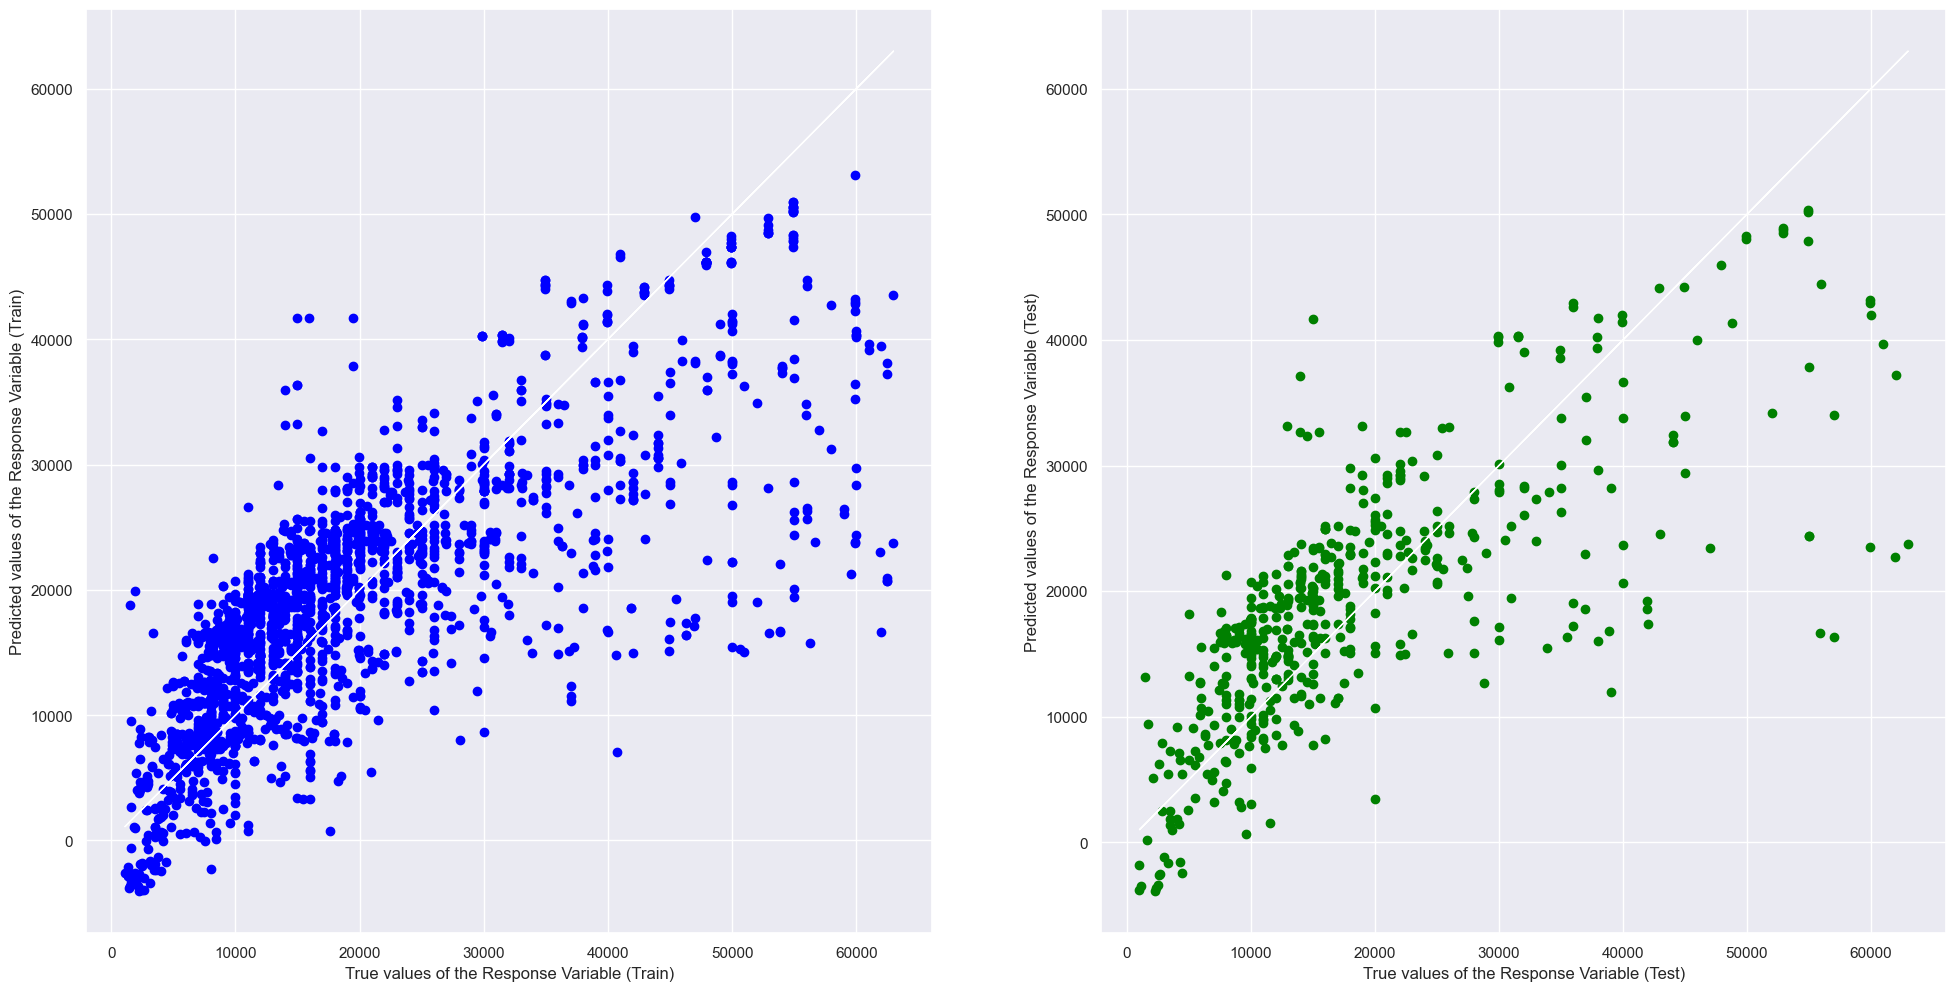

In [61]:
# Predict the values from Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [62]:
# Import mean_squared_error from sklearn
from sklearn.metrics import mean_squared_error

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.5911066795816621
Mean Squared Error (MSE) 	: 72921464.02820121

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.5520123925053189
Mean Squared Error (MSE) 	: 73368383.00166515



## Neural Network

Multi-layer Perceptron regressor

In [63]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=2000, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2)
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)


y_test_pred = regr.predict(X_test)
y_train_pred = regr.predict(X_train)


# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:",regr.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:",regr.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.9925439624842364
Mean Squared Error (MSE) 	: 249.76961676607996
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.9994930960818298
Mean Squared Error (MSE) 	: 15.55481354972606


/Users/wenjun/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [64]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
regr = MLPRegressor(random_state=1, max_iter=10000).fit(X_train, y_train)

y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:",regr.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:",regr.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.9944556002646042
Mean Squared Error (MSE) 	: 178.8769471966142
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.999999901532012
Mean Squared Error (MSE) 	: 0.0030517877015814854


## Conclusion

Linear Neural Network outperforms other models significantly, with R^2 values close to 1 (indicating a very good fit) and much lower MSE values (indicating more accurate predictions).

A classification tree tree predicts if a smartphone price is above or below $30,000, while a neural network outputs a numerical response instead of categorical, and tells us the exact predicted price of a smartphone based on the inputs of the predictor variables into the model

It provides more information for the smartphone sellers to price their phones accordingly